# ML Regression project - Store Sales Prediction (Time Series Forecasting)

# 1. Business Understanding

Businesses must forecast product demand to compete. This is especially true for brick-and-mortar grocery stores, which must dance delicately with how much inventory to buy. Predict a little over, and grocers are stuck with overstocked, perishable goods. Guess a little under, and popular items quickly sell out, leading to lost revenue and upset customers. More accurate forecasting, thanks to machine learning, could help ensure retailers make the customers happy by having just enough of the right products at the right time. Everyone hates when their favourite item is out of stock.

Current subjective forecasting methods for retail have little data to back them up and are unlikely to be automated. The problem becomes even more complex as retailers add new locations with unique needs, new products, ever-transitioning seasonal tastes, and unpredictable changing market conditions.For grocery stores, more accurate forecasting can decrease food waste related to overstocking and improve customer satisfaction.

In this project, we will use regression, a specific type of supervised machine learning that focuses on predicting continuous numerical values, to predict grocery store sales for the thousands of product families sold at Favorita stores located in Ecuador. The training data includes dates, store and product information, whether that item was being promoted, as well as the sales numbers.

The primary objective of this machine learning project is to develop an accurate predictive model for forecasting grocery store sales at Favorita stores in Ecuador. This model will help address the challenge faced by brick-and-mortar grocery stores in managing their inventory effectively. The goal is to predict sales for thousands of product families, considering various factors such as dates, store information, product details, and promotional activities. By achieving this objective, we aim to minimize overstocking, reduce food waste, and enhance customer satisfaction by ensuring that the right products are available in the right quantities at the right time.

For this project, we are dealing with a Time series forecasting problem. Time series forecasting involves predicting unknown values by collecting historical data, preparing it for algorithms to consume, and then predicting the future values based on patterns learned from the historical data.

We can do this with **Regression Models**: Employing linear regression, decision trees, random forests, or gradient boosting to account for various features like promotional status, product details, and store information.

To assess the performance of the predictive model, we will use metrics such as Root Mean Squared Logarithmic Error (RMSLE), Root Mean Squared Error (RMSE) and Mean Absolute Error (MAE). The errors will be aggregated to evaluate the forecast bias. To be certain whether the model tends to underpredict or overpredict sales, which can be crucial for inventory management.

The CRISP-DM (Cross-Industry Standard Process for Data Mining) framework will guide our project, ensuring a structured and iterative approach to solving the forecasting problem. This framework encompasses phases such as Business Understanding, Data Understanding, Data Preparation, Modeling, Evaluation, Deployment, and Maintenance, allowing us to systematically develop and deploy an effective sales forecasting solution for Favorita stores in Ecuador.


## Hypothesis

**Null Hypothesis (H0)**:
"There is no significant relationship between store sales and products are on promotion."

**Alternative Hypothesis (Ha)**:
"There is a significant relationship between store sales and products are on promotion."

## Research Questions

1. Is the train dataset complete (has all the required dates)?

2. Which dates have the lowest and highest sales for each year?

3. Did the earthquake impact sales?

4. Are certain groups of stores selling more products? (Cluster, city, state, type)

5. Are sales affected by promotions, oil prices and holidays?

6. What analysis can we get from the date and its extractable features?

7. What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)

# 2. Data Understanding

## Installing libraries  and Packages
Here is the section to import all the packages/libraries that will be used through this notebook.

In [1]:
import warnings 
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# Data handling
import pandas as pd
pd.set_option('display.max_columns', None)
import openpyxl
import numpy as np
from zipfile import ZipFile
import zipfile
from datetime import timedelta

# Vizualisation (Matplotlib, Plotly, Seaborn, etc. )
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import plotly.colors as colors
from plotly.subplots import make_subplots

# EDA (pandas-profiling, etc. )
import scipy.stats as stats
from scipy.stats import t, ttest_ind, chi2_contingency
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Feature Processing (Scikit-learn processing, etc. )
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.inspection import permutation_importance

# Machine Learning (Scikit-learn Estimators, Catboost, LightGBM, etc. )
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
import xgboost as xgb
from sklearn.neighbors import KNeighborsRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Hyperparameters Fine-tuning (Scikit-learn hp search, cross-validation, etc. )

# Other packages
import os, joblib

## Data Loading

In [2]:
# Extract train data from zip

with ZipFile("Zip files/train.zip", 'r') as zObject:
  
    # Extracting file in the zip
    zObject.extract(
        "train.csv", path="Dataset")
zObject.close()

In [3]:
# Read CSV and change date column from object to date type

holidays=pd.read_csv("Dataset/holidays_events.csv", parse_dates =['date'])
oil=pd.read_csv("Dataset/oil.csv", parse_dates =['date'])
sample=pd.read_csv("Dataset/sample_submission.csv")
stores=pd.read_csv("Dataset/stores.csv")
test=pd.read_csv("Dataset/test.csv", parse_dates =['date'])
train=pd.read_csv("Dataset/train.csv", parse_dates =['date'])
transactions=pd.read_csv("Dataset/transactions.csv", parse_dates =['date'])

## Exploratory Data Analysis

### Training data

In [4]:
# view last 5 rows
train.tail()

id       date  store_nbr                      family     sales  \
3000883  3000883 2017-08-15          9                     POULTRY   438.133   
3000884  3000884 2017-08-15          9              PREPARED FOODS   154.553   
3000885  3000885 2017-08-15          9                     PRODUCE  2419.729   
3000886  3000886 2017-08-15          9  SCHOOL AND OFFICE SUPPLIES   121.000   
3000887  3000887 2017-08-15          9                     SEAFOOD    16.000   

         onpromotion  
3000883            0  
3000884            1  
3000885          148  
3000886            8  
3000887            0

In [5]:
# view info
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB


#### Features and descriptions of train and test dataset

| Feature            | Description                                                                                                      |
| ---------------- | ---------------------------------------------------------------------------------------------------------------- |
| store_nbr           | identifies the store at which the products are sold.                                                                       |
| family    | identifies the type of product sold.                                                                    |
| sales          | gives the total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).                                                              |
| onpromotion       | gives the total number of items in a product family that were being promoted at a store at a given date.                                                             |



In [6]:
# Check for missing values using isna()
missing_values = train.isna().sum()

# Count missing values in each column
missing_counts = missing_values.sum()

# Check if there are any missing values in the entire DataFrame
any_missing = missing_values.any().any()

print("Missing Values in DataFrame:")
print(missing_values)
print("\nMissing Value Counts in Each Column:")
print(missing_counts)
print("\nAre there any missing values in the DataFrame?", any_missing)

Missing Values in DataFrame:
id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

Missing Value Counts in Each Column:
0

Are there any missing values in the DataFrame? False


In [7]:
# format numerical columns to 2 decimal places with comma separator
pd.options.display.float_format = '{:,.2f}'.format

# statistics for numerical columns
train.describe().T

count                           mean                  min  \
id          3,000,888.00                   1,500,443.50                 0.00   
date             3000888  2015-04-24 08:27:04.703088384  2013-01-01 00:00:00   
store_nbr   3,000,888.00                          27.50                 1.00   
sales       3,000,888.00                         357.78                 0.00   
onpromotion 3,000,888.00                           2.60                 0.00   

                             25%                  50%                  75%  \
id                    750,221.75         1,500,443.50         2,250,665.25   
date         2014-02-26 18:00:00  2015-04-24 12:00:00  2016-06-19 06:00:00   
store_nbr                  14.00                27.50                41.00   
sales                       0.00                11.00               195.85   
onpromotion                 0.00                 0.00                 0.00   

                             max        std  
id                  3,000,887.00 866,281.89  
date         2017-08-15 00:00:00        NaN  
store_nbr                  54.00      15.59  
sales                 124,717.00   1,102.00  
onpromotion               741.00      12.22

#### Frequencies of data points by yearly & monthly basis

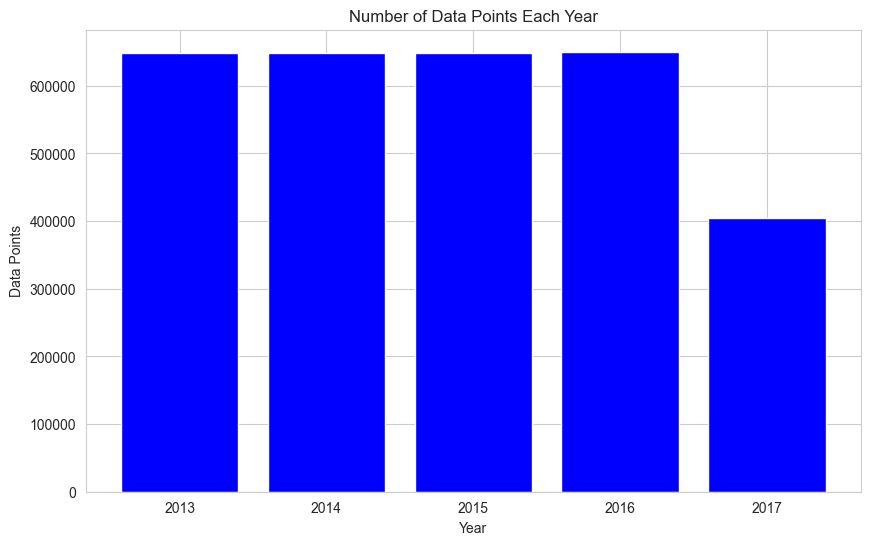

In [8]:
# copy train dataset so that we work with a copy, not the original
train_copy = train.copy()

# extracting the year column
train_copy['year'] = pd.to_datetime(train['date']).dt.year

# Grouping by year and count the data points
year_data = train_copy.groupby('year').size().reset_index(name='counts')

# Plotting the data
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(year_data['year'], year_data['counts'], color='blue')
ax.set_xticks(year_data['year'])
ax.set_title('Number of Data Points Each Year')
ax.set_xlabel('Year')
ax.set_ylabel('Data Points')

plt.show()

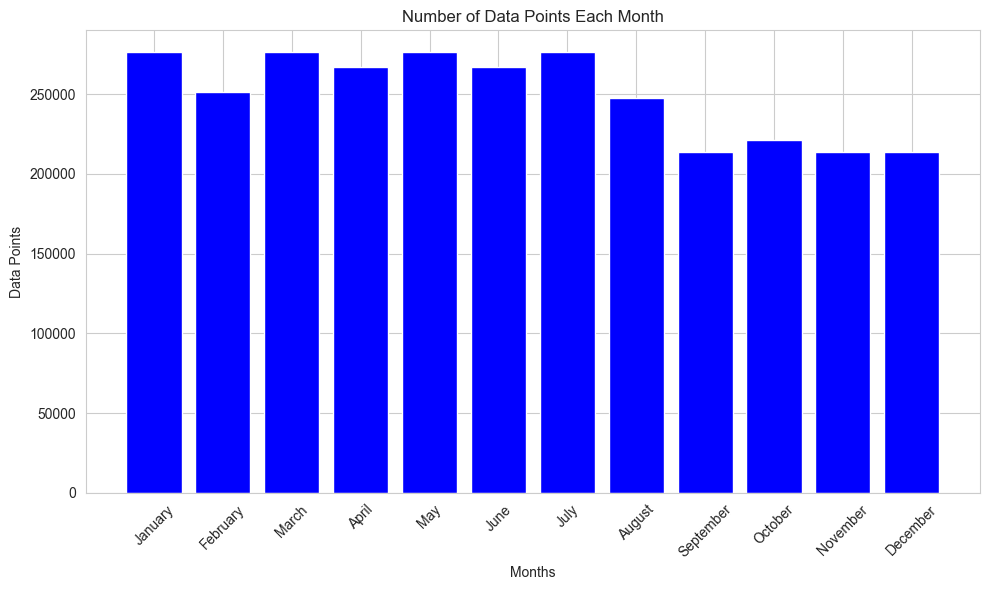

In [9]:
# extracting the month
train_copy['month'] = pd.to_datetime(train_copy['date']).dt.month

# Grouping by month and count the data points
monthly_data = train_copy.groupby('month').size().reset_index(name='counts')

# Renaming the month values for labeling
month_names = [
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
]
monthly_data['month'] = monthly_data['month'].apply(lambda x: month_names[x - 1])

# Plotting the data
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(monthly_data['month'], monthly_data['counts'], color='blue')
ax.set_title('Number of Data Points Each Month')
ax.set_xlabel('Months')
ax.set_ylabel('Data Points')

plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Ensure labels are not cut off
plt.show()

#### Total sales by store

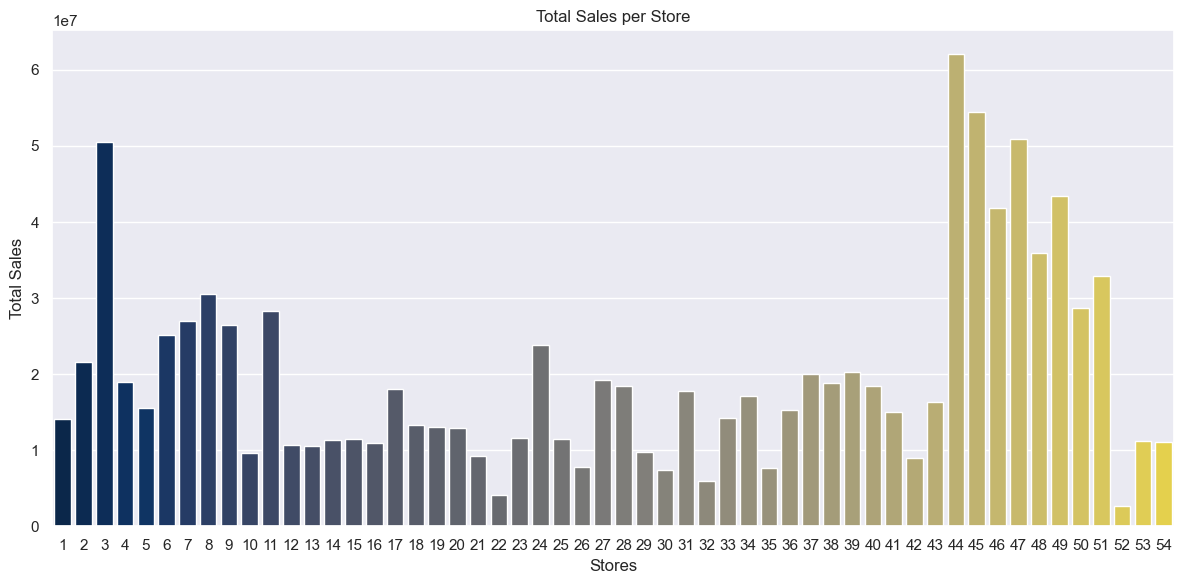

In [10]:
# Filter rows where unit_sales > 0
train_copy = train_copy[train['sales'] > 0]

# Group by 'store_nbr' and calculate the sum of 'unit_sales'
store_unit_sales = train_copy.groupby('store_nbr')['sales'].sum().reset_index()

# Set the figure size
sns.set(rc={'figure.figsize': (12, 6)})

# Create a barplot
sns.barplot(x='store_nbr', y='sales', data=store_unit_sales, palette='cividis')

# Set titles and labels
plt.title('Total Sales per Store')
plt.xlabel('Stores')
plt.ylabel('Total Sales')

# Show the plot
plt.tight_layout()
plt.show()

- Store number 44,45 have the highest total sales

#### Total sales daily

In [11]:
# Filter rows where unit_sales > 0
train_copy = train_copy[train_copy['sales'] > 0]

# Group by 'date' and calculate the sum of 'sales'
sales_date_agg = train_copy.groupby('date')['sales'].sum().reset_index()

# Create a lineplot using Plotly Express
fig = px.line(sales_date_agg, x='date', y='sales', title='Plot of Total Sales Over Time (Daily)')
fig.update_layout(width=1200, height=600)

# Add a range slider
fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
# Show the plot
fig.show()

- upward trend year on year

### Test data

- The dates in the test data are for the 15 days after the last date in the training data.

In [12]:
# view first 5 rows
test.head()

id       date  store_nbr      family  onpromotion
0  3000888 2017-08-16          1  AUTOMOTIVE            0
1  3000889 2017-08-16          1   BABY CARE            0
2  3000890 2017-08-16          1      BEAUTY            2
3  3000891 2017-08-16          1   BEVERAGES           20
4  3000892 2017-08-16          1       BOOKS            0

In [13]:
# view info
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   id           28512 non-null  int64         
 1   date         28512 non-null  datetime64[ns]
 2   store_nbr    28512 non-null  int64         
 3   family       28512 non-null  object        
 4   onpromotion  28512 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 1.1+ MB


In [14]:
# check for missing values

test.isna().sum()

id             0
date           0
store_nbr      0
family         0
onpromotion    0
dtype: int64

### Transactions Dataset

- Contains date, store_nbr and transaction made on that specific date.

In [15]:
# view first 5 rows
transactions.head()

date  store_nbr  transactions
0 2013-01-01         25           770
1 2013-01-02          1          2111
2 2013-01-02          2          2358
3 2013-01-02          3          3487
4 2013-01-02          4          1922

In [16]:
# view info
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          83488 non-null  datetime64[ns]
 1   store_nbr     83488 non-null  int64         
 2   transactions  83488 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.9 MB


In [17]:
# check for missing values

transactions.isna().sum()

date            0
store_nbr       0
transactions    0
dtype: int64

In [18]:
# Visualize transactions over the years with plotly

fig = px.line(transactions, y="transactions",x='date', title="Transaction data over time")

# enable range slider with range selector
fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig.show()

- Big spikes is transactions in december every year; indicates seasonality

### Stores Dataset

- Store metadata, including city, state, type, and cluster.

- cluster is a grouping of similar stores.

In [19]:
# view first 5 rows
stores.head()

store_nbr           city                           state type  cluster
0          1          Quito                       Pichincha    D       13
1          2          Quito                       Pichincha    D       13
2          3          Quito                       Pichincha    D        8
3          4          Quito                       Pichincha    D        9
4          5  Santo Domingo  Santo Domingo de los Tsachilas    D        4

In [20]:
# view info
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


In [21]:
# check for missing values

stores.isna().sum()

store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

### Oil Dataset

- Daily oil price which includes values during both the train and test data timeframes. (Ecuador is an oil-dependent country and its economical health is highly vulnerable to shocks in oil prices.)

In [22]:
# view first 5 rows
oil.head()

date  dcoilwtico
0 2013-01-01         NaN
1 2013-01-02       93.14
2 2013-01-03       92.97
3 2013-01-04       93.12
4 2013-01-07       93.20

In [23]:
# view info
oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1218 non-null   datetime64[ns]
 1   dcoilwtico  1175 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.2 KB


In [24]:
# check for missing values

oil.isna().sum()

date           0
dcoilwtico    43
dtype: int64

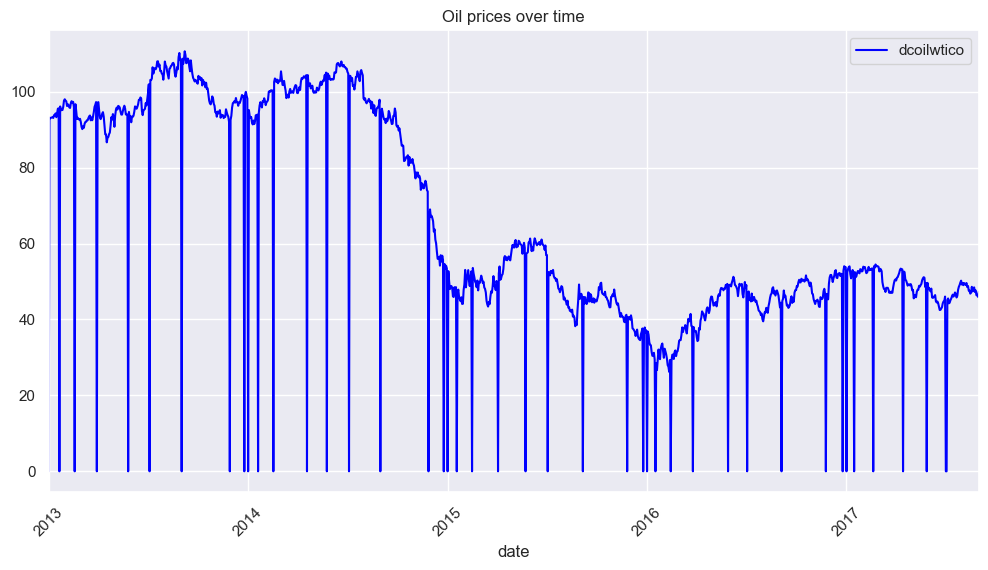

In [25]:
# Oil prices over time

ax = oil.groupby(['date'], as_index=False)["dcoilwtico"].sum().plot(
    "date", "dcoilwtico", figsize=(12,6), title="Oil prices over time", color='blue')

plt.tick_params(axis='x', labelrotation=45)

### Holiday/Events Dataset

- Holidays and Events, with metadata

NOTE: Pay special attention to the transferred column. A holiday that is transferred officially falls on that calendar day but was moved to another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was celebrated, look for the corresponding row where type is Transfer.

For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge.

- Additional holidays are days added a regular calendar holiday, for example, as typically happens around Christmas (making Christmas Eve a holiday).

In [26]:
# view forst 5 rows
holidays.head()

date     type    locale locale_name                    description  \
0 2012-03-02  Holiday     Local       Manta             Fundacion de Manta   
1 2012-04-01  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   
2 2012-04-12  Holiday     Local      Cuenca            Fundacion de Cuenca   
3 2012-04-14  Holiday     Local    Libertad      Cantonizacion de Libertad   
4 2012-04-21  Holiday     Local    Riobamba      Cantonizacion de Riobamba   

   transferred  
0        False  
1        False  
2        False  
3        False  
4        False

In [27]:
# view info
holidays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         350 non-null    datetime64[ns]
 1   type         350 non-null    object        
 2   locale       350 non-null    object        
 3   locale_name  350 non-null    object        
 4   description  350 non-null    object        
 5   transferred  350 non-null    bool          
dtypes: bool(1), datetime64[ns](1), object(4)
memory usage: 14.1+ KB


In [28]:
# check for missing values

holidays.isna().sum()

date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64

### Research Questions

#### 1. Is the train dataset complete (has all the required dates)?

In [29]:
# Check for missing values
if train.isnull().values.any():
  print("The dataset is not complete. There are missing values.")
else:
  print("The dataset is complete.")


The dataset is complete.


##### Date completion

In [30]:
# Checking for missing dates
# Min and max dates (range of dates)

data_train_start = train.date.min()
data_train_end = train.date.max()

# Generate a date range from start_date to end_date
date_range = pd.date_range(start=data_train_start,end=data_train_end)

# Use the difference between the date_range and the unique dates in the sales data to find missing dates
missing_dates = date_range.difference(train['date'])

print("Missing dates:", missing_dates)

Missing dates: DatetimeIndex(['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25'], dtype='datetime64[ns]', freq=None)


- The train dataset is mising 4 dates.These missing dates follow a pattern (december 25th) from 2013-2016. This date is a worldwide holiday, and also a holiday in Ecuador.
- The assumption is that no data was collected on this day every year as the shops may be closed down on christmas each year.

In [31]:
missing_df = list(missing_dates)
print(pd.DataFrame(missing_df))

           0
0 2013-12-25
1 2014-12-25
2 2015-12-25
3 2016-12-25


In [32]:
train.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion'], dtype='object')

In [33]:
# Add missing dates in a DataFrame

new_dates = pd.DataFrame(missing_df, columns = ['date'])
new_dates

date
0 2013-12-25
1 2014-12-25
2 2015-12-25
3 2016-12-25

- let us add the missing dates to the train dataset

In [34]:
train = pd.concat([train, new_dates], ignore_index=False)
train.tail(10)

id       date  store_nbr                      family  \
3000882 3,000,882.00 2017-08-15       9.00     PLAYERS AND ELECTRONICS   
3000883 3,000,883.00 2017-08-15       9.00                     POULTRY   
3000884 3,000,884.00 2017-08-15       9.00              PREPARED FOODS   
3000885 3,000,885.00 2017-08-15       9.00                     PRODUCE   
3000886 3,000,886.00 2017-08-15       9.00  SCHOOL AND OFFICE SUPPLIES   
3000887 3,000,887.00 2017-08-15       9.00                     SEAFOOD   
0                NaN 2013-12-25        NaN                         NaN   
1                NaN 2014-12-25        NaN                         NaN   
2                NaN 2015-12-25        NaN                         NaN   
3                NaN 2016-12-25        NaN                         NaN   

           sales  onpromotion  
3000882     6.00         0.00  
3000883   438.13         0.00  
3000884   154.55         1.00  
3000885 2,419.73       148.00  
3000886   121.00         8.00  
3000887    16.00         0.00  
0            NaN          NaN  
1            NaN          NaN  
2            NaN          NaN  
3            NaN          NaN

In [35]:
train.isna().sum()

id             4
date           0
store_nbr      4
family         4
sales          4
onpromotion    4
dtype: int64

In [36]:
train[['sales','onpromotion']] = train[['sales','onpromotion']].fillna(0.)

# Apply linear interpolation to the selected "id" column. 
train.id = train.id.interpolate(method="linear")

In [37]:
train.isna().sum()

id             0
date           0
store_nbr      4
family         4
sales          0
onpromotion    0
dtype: int64

- We will deal with missing values these later on.

#### 2. Which dates have the lowest and highest sales for each year?

In [38]:
# Highest sales date in each year

train_copy['year'] = train_copy['date'].dt.year
max_sales = train_copy.groupby('year')['sales'].idxmax()
Result_max = train.loc[max_sales]
Result_max

id       date  store_nbr     family      sales  onpromotion
562596    562,596.00 2013-11-12      44.00  GROCERY I  46,271.00         0.00
1257246 1,257,246.00 2014-12-08      35.00  GROCERY I  45,361.00         3.00
1916586 1,916,586.00 2015-12-14      35.00  GROCERY I  40,351.46         7.00
2163723 2,163,723.00 2016-05-02       2.00  GROCERY I 124,717.00        59.00
2760297 2,760,297.00 2017-04-02       9.00  GROCERY I  38,422.62        73.00

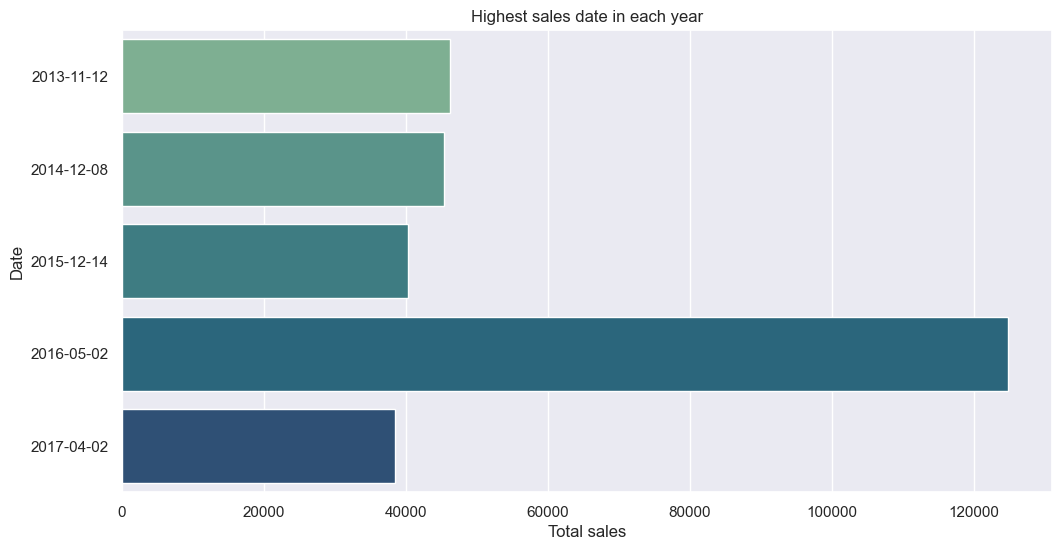

In [39]:
# Horizontal bar chart of dates with highest sales each year

sns.barplot(data=Result_max, y="date", x="sales", palette='crest')
plt.ylabel("Date")
plt.xlabel("Total sales")
plt.title("Highest sales date in each year")
plt.show()

- 2016/05/02 has the highest sales (124,717)

In [40]:
# lowest sales date in each year

min_sales = train_copy.groupby('year')['sales'].idxmin()
Result_min = train.loc[min_sales]
Result_min

id       date  store_nbr   family  sales  onpromotion
387782    387,782.00 2013-08-06      39.00  SEAFOOD   0.12         0.00
1252052 1,252,052.00 2014-12-05      39.00  SEAFOOD   0.19         0.00
1756358 1,756,358.00 2015-09-15      39.00  SEAFOOD   0.20         0.00
2256638 2,256,638.00 2016-06-23      26.00  SEAFOOD   0.40         1.00
2666498 2,666,498.00 2017-02-09      26.00  SEAFOOD   0.43         0.00

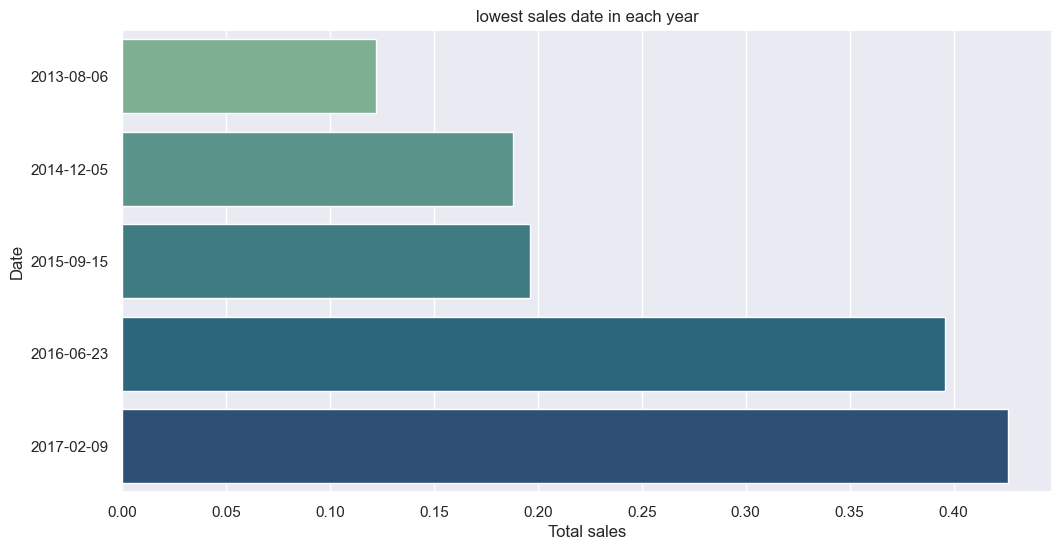

In [41]:
# Horizontal bar chart of dates with lowest sales each year

sns.barplot(data=Result_min, y="date", x="sales", palette='crest')
plt.ylabel("Date")
plt.xlabel("Total sales")
plt.title("lowest sales date in each year")
plt.show()

- 2013/08/06 has the lowest sales (0.12)

#### 3. Did the earthquake impact sales?

The 2016 Ecuador earthquake occurred on April 16 at 18:58:37 ECT with a moment magnitude of 7.8

In [42]:
# Set the 'date' column as the index

train_copy.set_index('date', inplace=True)

# Resample to weekly frequency, aggregating with mean

sales_daily_mean = train_copy["sales"].resample('D').mean()
sales_weekly_mean = train_copy["sales"].resample('W').mean()

Text(0.5, 1.0, 'April and May 2016 total sales')

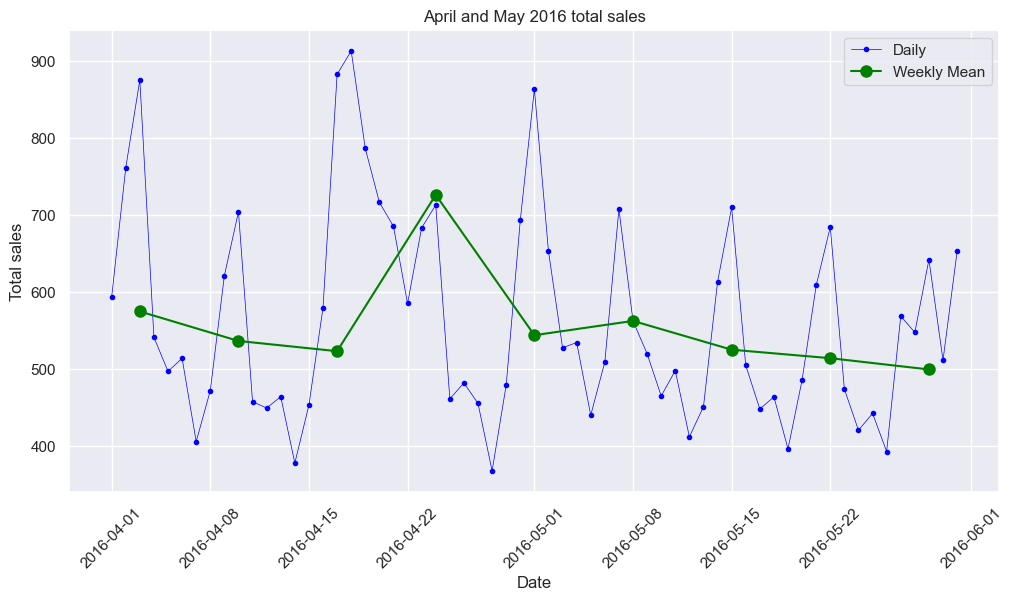

In [43]:
# Sales for April to May 2016.
start, end = '2016-04', '2016-05'

# Analyse before and after the earthquake

fig, ax = plt.subplots(figsize=(12,6))

color_daily = 'blue'
color_weekly = 'green'

ax.plot(sales_daily_mean.loc[start:end], marker='.', linestyle='-', linewidth=0.5, label='Daily', color=color_daily)
ax.plot(sales_weekly_mean.loc[start:end], marker='o', markersize=8, linestyle='-', label='Weekly Mean', color=color_weekly)
ax.set_ylabel("Total sales")
ax.set_xlabel("Date")
ax.tick_params(axis='x', labelrotation=45)
ax.legend()
ax.set_title("April and May 2016 total sales")

In the week of the earthquake (from April 14th to April 21st), daily and weekly sales increased during this week, reaching a peak on the days after the earthquake (18th), but then experienced a sharp decline the next 4 days following the earthquake, returning to normalcy.

#### 4. Are certain groups of stores selling more products? (Cluster, city, state, type)

In [44]:
# Merge train and stores datasets

train_stores = pd.merge(train, stores)

train_stores.head()

id       date  store_nbr      family  sales  onpromotion   city  \
0 0.00 2013-01-01       1.00  AUTOMOTIVE   0.00         0.00  Quito   
1 1.00 2013-01-01       1.00   BABY CARE   0.00         0.00  Quito   
2 2.00 2013-01-01       1.00      BEAUTY   0.00         0.00  Quito   
3 3.00 2013-01-01       1.00   BEVERAGES   0.00         0.00  Quito   
4 4.00 2013-01-01       1.00       BOOKS   0.00         0.00  Quito   

       state type  cluster  
0  Pichincha    D       13  
1  Pichincha    D       13  
2  Pichincha    D       13  
3  Pichincha    D       13  
4  Pichincha    D       13

##### Store sales by cluster

In [45]:
# Sum of sales by cluster

sales_clusters = train_stores.groupby("cluster", as_index=False)["sales"].sum()
sales_clusters.sort_values(by='sales', ascending=False)

cluster          sales
13       14 157,430,523.08
5         6 114,254,386.74
7         8 107,928,246.70
10       11 100,614,275.93
9        10  85,324,430.43
2         3  75,628,703.46
12       13  72,102,248.79
4         5  62,087,553.25
14       15  55,296,949.37
0         1  54,376,751.96
3         4  49,443,442.97
16       17  32,911,489.54
8         9  30,561,081.05
1         2  28,916,403.50
11       12  18,030,969.25
6         7  15,478,120.49
15       16  13,259,375.69

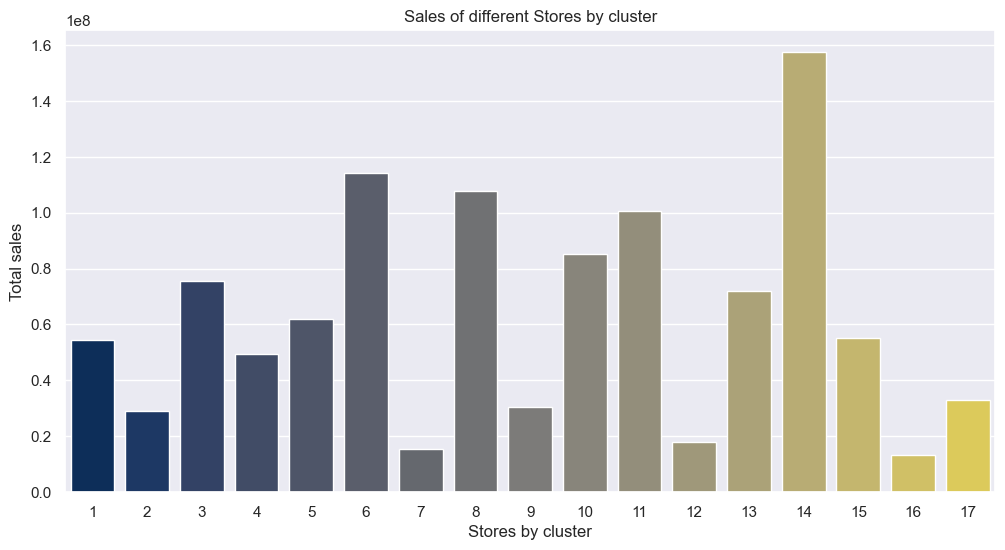

In [46]:
# vertical Bar chart of sales by cluster

ax = sns.barplot(data=sales_clusters, x = "cluster", y = "sales", palette='cividis')
plt.xlabel("Stores by cluster")
plt.ylabel("Total sales")
plt.title("Sales of different Stores by cluster")
plt.show()

- cluster 14 has the highest sales. cluster 16 has the lowest sales.

##### Store sales by city

In [47]:
# Sum of sales by city

sales_city = train_stores.groupby("city", as_index=False)["sales"].sum()
sales_city.sort_values(by='sales', ascending=False)

city          sales
18          Quito 556,741,836.83
8       Guayaquil 122,967,260.48
3          Cuenca  49,168,596.03
0          Ambato  40,304,401.30
21  Santo Domingo  35,834,323.04
13        Machala  33,386,796.54
2         Cayambe  28,325,558.48
10      Latacunga  21,182,263.78
4           Daule  19,188,021.38
12           Loja  18,859,999.26
1        Babahoyo  17,746,872.70
6      Esmeraldas  16,391,692.21
11       Libertad  15,322,431.10
17        Quevedo  14,178,501.29
14          Manta  13,912,337.02
7        Guaranda  13,049,509.84
9          Ibarra  11,451,270.02
20        Salinas  11,420,997.87
19       Riobamba  11,387,918.75
5       El Carmen  11,057,483.12
15         Playas   7,676,679.42
16           Puyo   4,090,201.74

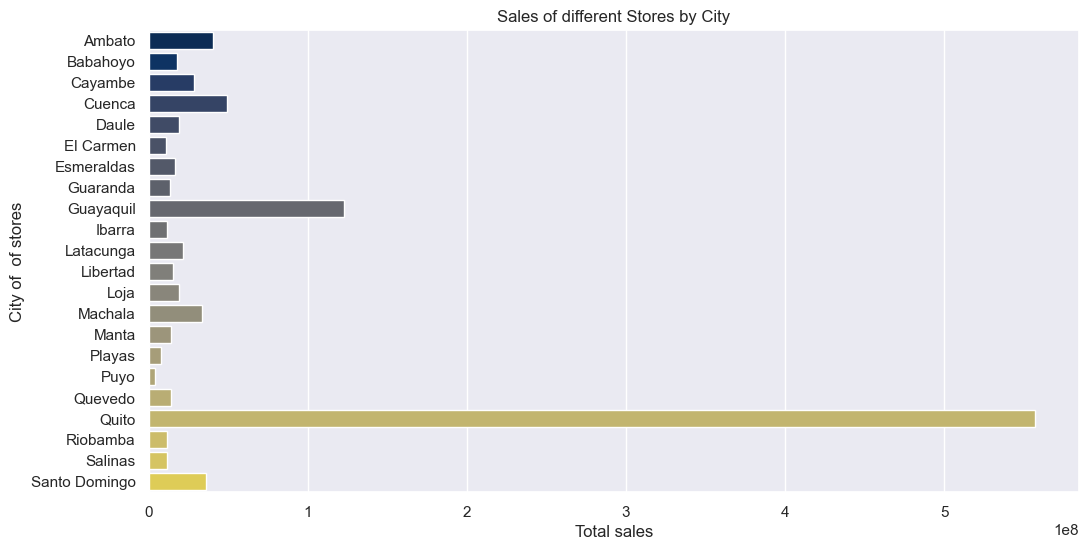

In [48]:
# horizontal Bar chart of sales by city

sns.barplot(data=sales_city, y = "city", x = "sales", palette='cividis')
plt.ylabel("City of  of stores")
plt.xlabel("Total sales")
plt.title("Sales of different Stores by City")
plt.show()

- Quito has the highest total sales, as it is the capital, and Puyo the lowest

##### Store sales by state

In [49]:
# Sum of sales by state

sales_state = train_stores.groupby("state", as_index=False)["sales"].sum()
sales_state.sort_values(by='sales', ascending=False)

state          sales
12                       Pichincha 585,067,395.31
6                           Guayas 165,154,392.38
0                            Azuay  49,168,596.03
15                      Tungurahua  40,304,401.30
14  Santo Domingo de los Tsachilas  35,834,323.04
4                           El Oro  33,386,796.54
9                         Los Rios  31,925,373.99
10                          Manabi  24,969,820.13
3                         Cotopaxi  21,182,263.78
8                             Loja  18,859,999.26
5                       Esmeraldas  16,391,692.21
1                          Bolivar  13,049,509.84
7                         Imbabura  11,451,270.02
13                     Santa Elena  11,420,997.87
2                       Chimborazo  11,387,918.75
11                         Pastaza   4,090,201.74

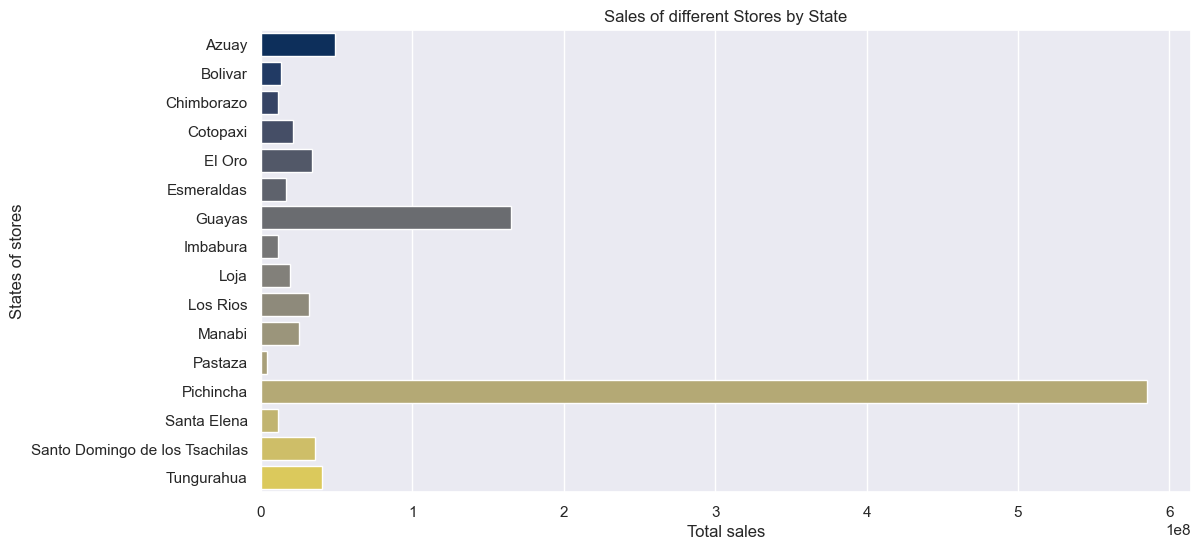

In [50]:
# horizontal Bar chart of sales by state

sns.barplot(data=sales_state, y = "state", x = "sales", palette='cividis')
plt.ylabel("States of stores")
plt.xlabel("Total sales")
plt.title("Sales of different Stores by State")
plt.show()

- Pichincha has the highest total sales
- Pastaza has the lowest total sales

##### Store sales by type

In [51]:
# Sum of sales by store type

sales_type = train_stores.groupby("type", as_index=False)["sales"].sum()
sales_type.sort_values(by='sales', ascending=False)

type          sales
0    A 353,043,841.80
3    D 351,083,296.86
2    C 164,434,742.56
1    B 145,260,635.13
4    E  59,822,435.84

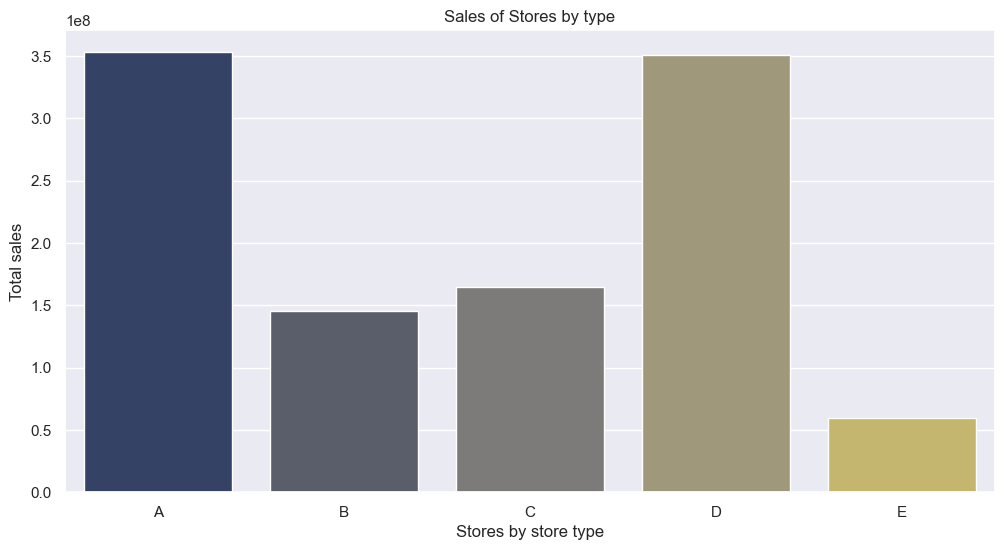

In [52]:
# vertical Bar chart of sales by store type

sns.barplot(data=sales_type, x = "type", y = "sales", palette='cividis')
plt.xlabel("Stores by store type")
plt.ylabel("Total sales")
plt.title("Sales of Stores by type")
plt.show()

- type A nd D have the highest total sales

#### 5. Are sales affected by promotions, oil prices and holidays?

##### Sales and promotions

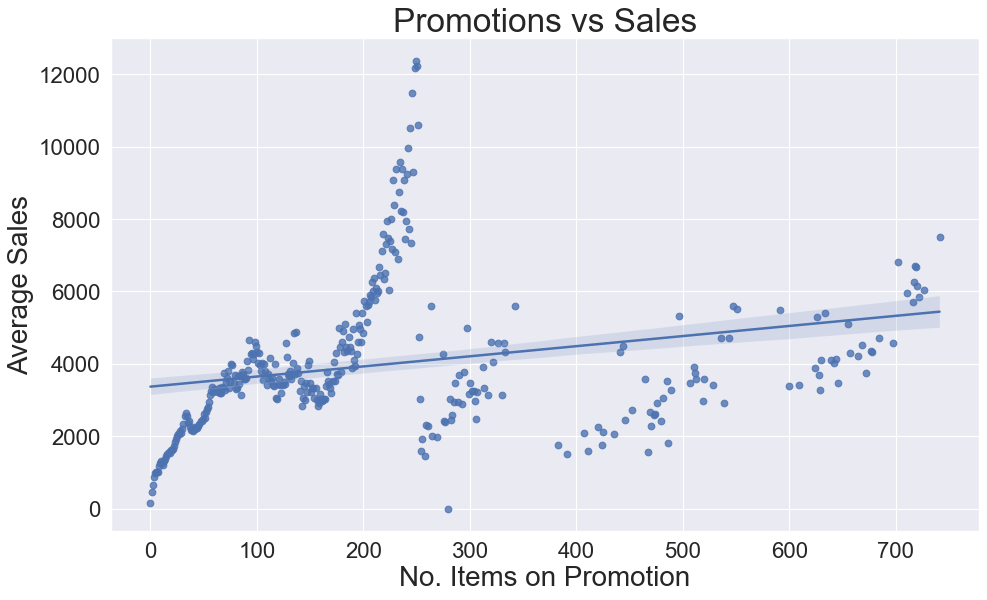

In [53]:
# Copy the data_train dataset
data_sales_prom = train.copy()

# Plot the average sales vs items on promotion
data_sales_prom = data_sales_prom.groupby(['onpromotion'],as_index=False)['sales'].mean()
plt.figure(figsize=(14,8),dpi=80)
sns.regplot(data=data_sales_prom, x='onpromotion',y='sales')
plt.ylabel("Average Sales",fontsize=25)
plt.title("Promotions vs Sales",fontsize=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.xlabel('No. Items on Promotion',fontsize=25)
plt.show()

- The average sales increase when there are more items on promotion.

##### Sales and oil prices

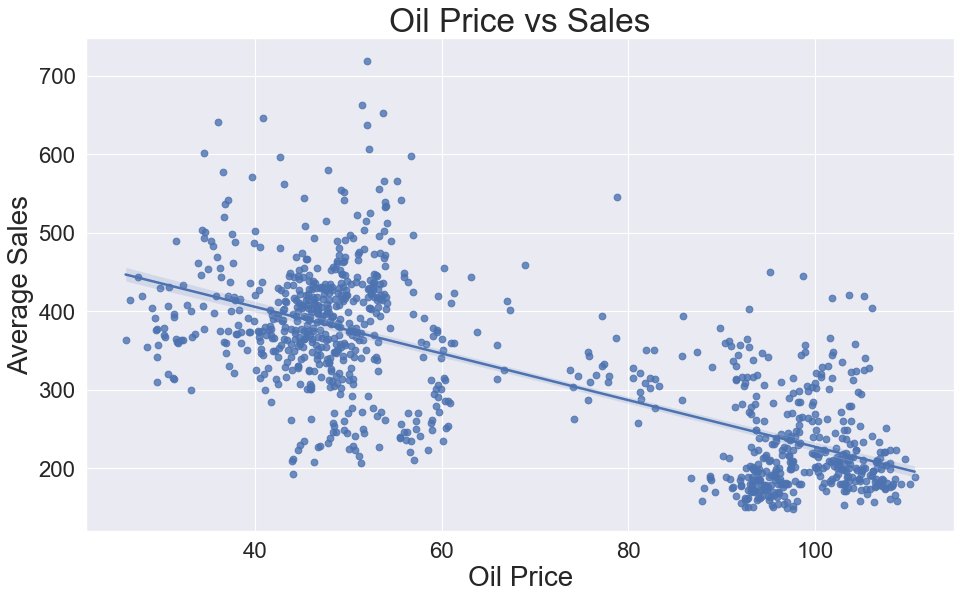

In [54]:
# Copy the data_train dataset
data_sales_oil = train.copy()

# Merge the sales and oil price datasets
data_sales_oil = train.merge(oil,on=["date"],how="left")

# Plot the average sales vs oil prices
data_sales_oil = data_sales_oil.groupby(['dcoilwtico'],as_index=False)['sales'].mean()
plt.figure(figsize=(14,8),dpi=80)
sns.regplot(data=data_sales_oil, x='dcoilwtico', y='sales')
plt.ylabel("Average Sales",fontsize=25)
plt.title("Oil Price vs Sales",fontsize=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.xlabel('Oil Price',fontsize=25)
plt.show()

- Higher oil prices equal lower average sales

##### Sales and holidays

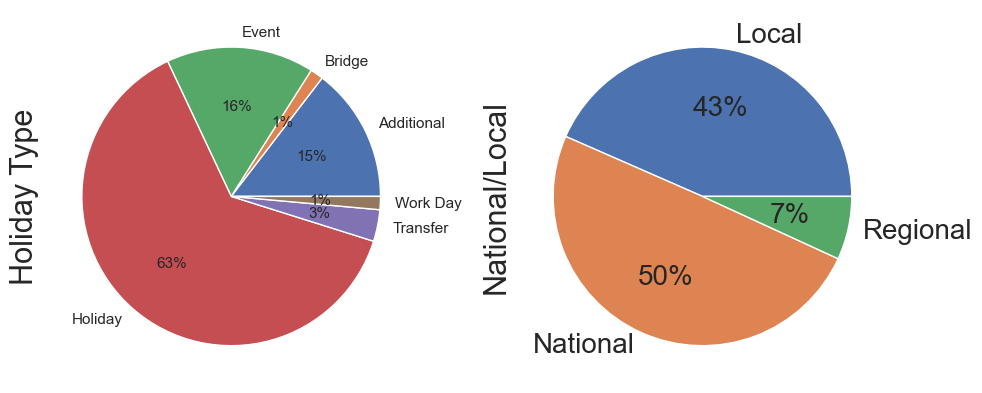

In [55]:
def label_function(val):
    return f'{val:.0f}%'

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))

holidays.groupby('type').size().plot(kind='pie',autopct=label_function,textprops={'fontsize':11},ax=ax1)
holidays.groupby('locale').size().plot(kind='pie',autopct=label_function,textprops={'fontsize': 20},ax=ax2)

ax1.set_ylabel('Holiday Type',size=22)
ax2.set_ylabel('National/Local',size=22)
plt.tight_layout()
plt.show()

- The main type of holiday are normal calendar holidays. Half of them are national holidays.

In [56]:
# merge train and holidays dataset

merge_2 = train_copy.merge(
    holidays, 
    how='left', 
    on=['date'])
    
merge_2.reset_index()
merge_2.head()

date   id  store_nbr        family  sales  onpromotion  year  month  \
0 2013-01-01  563         25        BEAUTY   2.00            0  2013      1   
1 2013-01-01  564         25     BEVERAGES 810.00            0  2013      1   
2 2013-01-01  566         25  BREAD/BAKERY 180.59            0  2013      1   
3 2013-01-01  568         25      CLEANING 186.00            0  2013      1   
4 2013-01-01  569         25         DAIRY 143.00            0  2013      1   

      type    locale locale_name         description transferred  
0  Holiday  National     Ecuador  Primer dia del ano       False  
1  Holiday  National     Ecuador  Primer dia del ano       False  
2  Holiday  National     Ecuador  Primer dia del ano       False  
3  Holiday  National     Ecuador  Primer dia del ano       False  
4  Holiday  National     Ecuador  Primer dia del ano       False

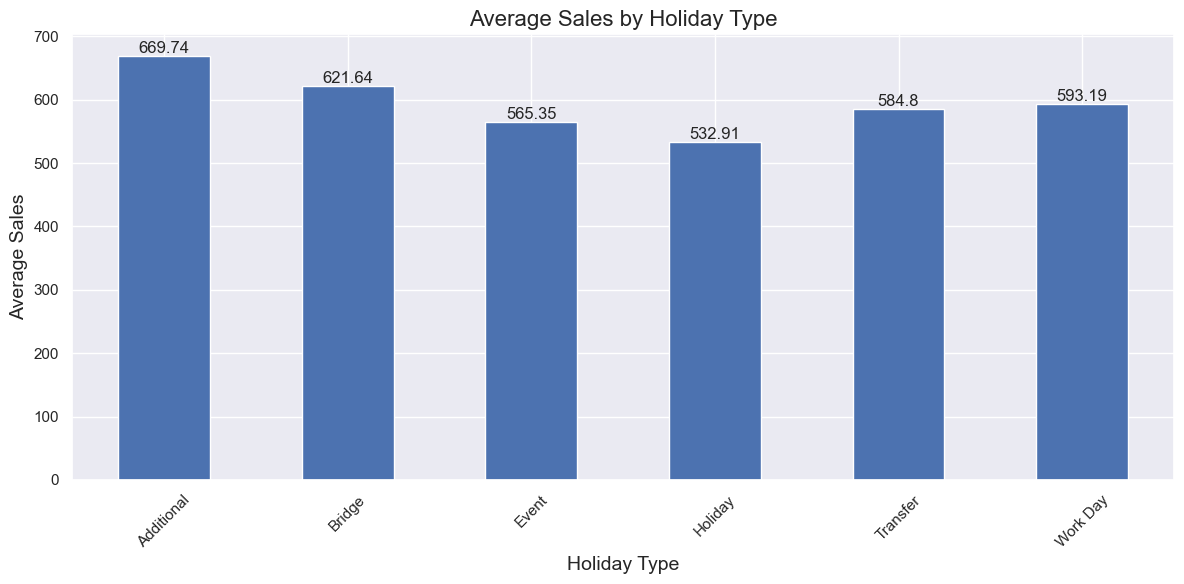

In [57]:
# Group the data by holiday type and calculate the average sales for each type
avg_sales_by_type = merge_2.groupby("type").agg({"sales": "mean"})

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(12, 6))

# Plot a bar chart of the average sales by holiday type
avg_sales_by_type.plot(kind="bar", y="sales", ax=ax, legend=False)

# Add labels to the bars
for index, value in enumerate(avg_sales_by_type["sales"]):
    plt.text(index, value, str(round(value, 2)), ha='center', va='bottom', fontsize=12)

# Add a title and labels
ax.set_title("Average Sales by Holiday Type", fontsize=16)
ax.set_xlabel("Holiday Type", fontsize=14)
ax.set_ylabel("Average Sales", fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

- Additional holidays have the highest average sales.
* Additional holidays are days added a regular calendar holiday, for example, as typically happens around Christmas (making Christmas Eve a holiday).

#### 6. What analysis can we get from the date and its extractable features?

In [58]:
# Function to extract features from date column

def getDateFeatures(df, date):
    df['date'] = pd.to_datetime(df[date])
    df['month'] = df['date'].dt.month
    df['Month'] = df['date'].dt.month_name()
    df['Day'] = df['date'].dt.day_name()
    df['day_of_month'] = df['date'].dt.day
    df['day_of_year'] = df['date'].dt.dayofyear
    df['week_of_year'] = df['date'].dt.isocalendar().week
    df['day_of_week'] = df['date'].dt.dayofweek
    df['year'] = df['date'].dt.year
    df["is_weekend"] = np.where(df['day_of_week'] > 4, 1, 0)
    df['quarter'] = df['date'].dt.quarter
    return df

In [59]:
# run our train data through our function

train_copy = train_copy.reset_index()
train_data = getDateFeatures(train_copy, "date")
train_data.head()

date   id  store_nbr        family  sales  onpromotion  year  month  \
0 2013-01-01  563         25        BEAUTY   2.00            0  2013      1   
1 2013-01-01  564         25     BEVERAGES 810.00            0  2013      1   
2 2013-01-01  566         25  BREAD/BAKERY 180.59            0  2013      1   
3 2013-01-01  568         25      CLEANING 186.00            0  2013      1   
4 2013-01-01  569         25         DAIRY 143.00            0  2013      1   

     Month      Day  day_of_month  day_of_year  week_of_year  day_of_week  \
0  January  Tuesday             1            1             1            1   
1  January  Tuesday             1            1             1            1   
2  January  Tuesday             1            1             1            1   
3  January  Tuesday             1            1             1            1   
4  January  Tuesday             1            1             1            1   

   is_weekend  quarter  
0           0        1  
1           0        1  
2           0        1  
3           0        1  
4           0        1

##### Sales on Pay Day (Semi-Monthly)

In [60]:
# list with semi monthly pay day range (15th and last day 30/31st of the month)

pay_day = pd.date_range(start=train_data.date.min(), end=train_data.date.max(), freq='SM').astype('str').tolist()

In [61]:
# create payday column

train_data["pay_day"] = np.where(train_data["date"].isin(pay_day), 1, 0)
train_data['pay_day'].value_counts()

pay_day
0    1925095
1     136663
Name: count, dtype: int64

- We will get the average sales to see whether there is a difference in payday sales and other sales

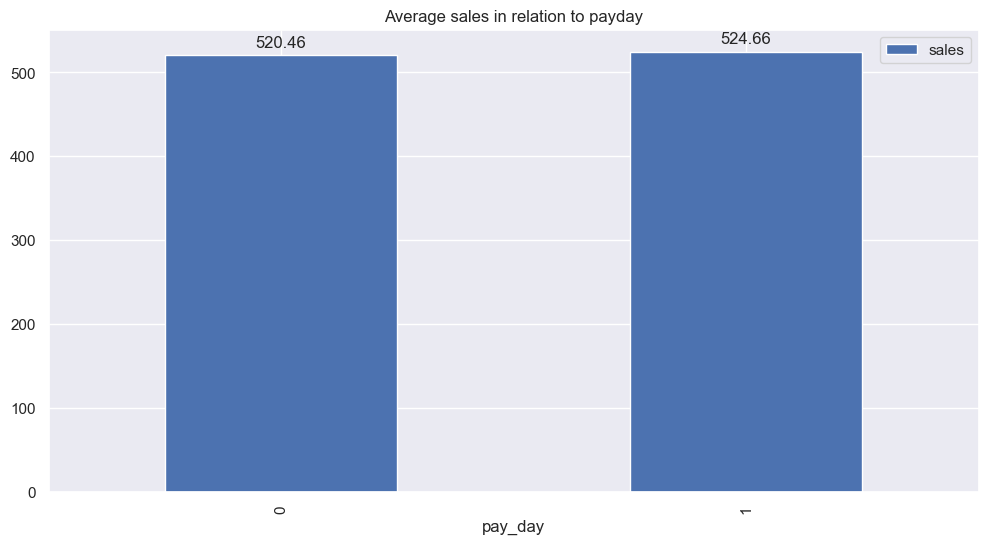

In [62]:
# Plot the average sales in relation to payday

ax = train_data.groupby(["pay_day"], as_index=False)['sales'].mean()\
                                    .plot("pay_day", "sales", kind="bar", figsize=(12,6),
                                         title="Average sales in relation to payday")

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points')


- Average payday sales are slightly higher than non-payday sales

##### Sales by day of the month

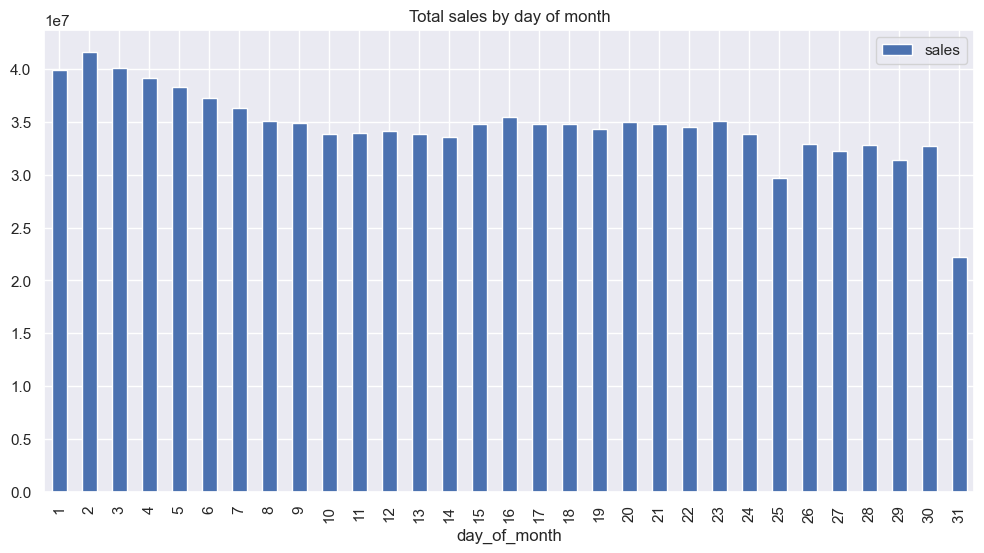

In [63]:
# plot the sum of sales by day of the month
# which day of the month has the most sales?

ax = train_data.groupby(["day_of_month"], as_index=False)["sales"].sum()\
                                    .plot("day_of_month", "sales", kind="bar", figsize=(12,6),
                                         title="Total sales by day of month")

- Beginning of the month has high sales (1st - 3rd), with a gradual decline afterwards, and slight increase mid-month.

##### Sales by week of the year

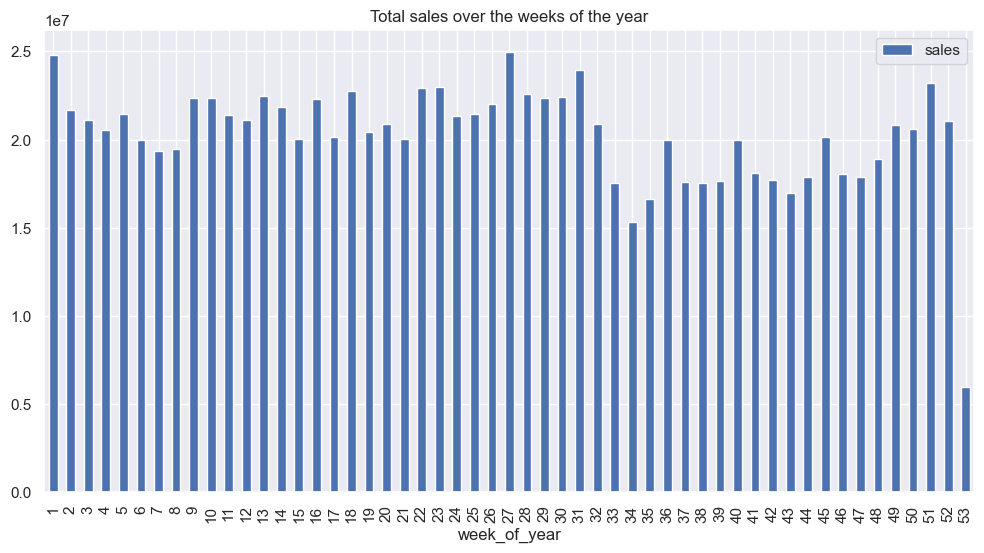

In [64]:
# plot the sum of sales by the weeks of the year

sales_by_week = train_data.groupby(["week_of_year"], as_index=False)['sales'].sum()

ax = sales_by_week.plot("week_of_year", "sales", kind="bar", figsize=(12, 6),
                         title="Total sales over the weeks of the year")

- First week and mid year (week 27) have the highest sales

##### Sales by month

In [65]:
# group the sum of sales by month of the year
# which month has the highest sales?

purchase_month = train_data.groupby("Month", as_index=False)["sales"].sum().sort_values(by="sales", ascending=False)
purchase_month = purchase_month.reset_index(drop=True)
purchase_month

Month          sales
0        July 103,363,060.69
1       March  97,228,487.15
2    December  97,027,840.76
3        June  94,516,703.29
4     January  94,442,152.32
5         May  94,399,137.02
6       April  90,668,117.56
7      August  83,472,376.84
8    February  80,637,229.44
9    November  80,335,788.06
10    October  80,080,379.16
11  September  77,473,679.92

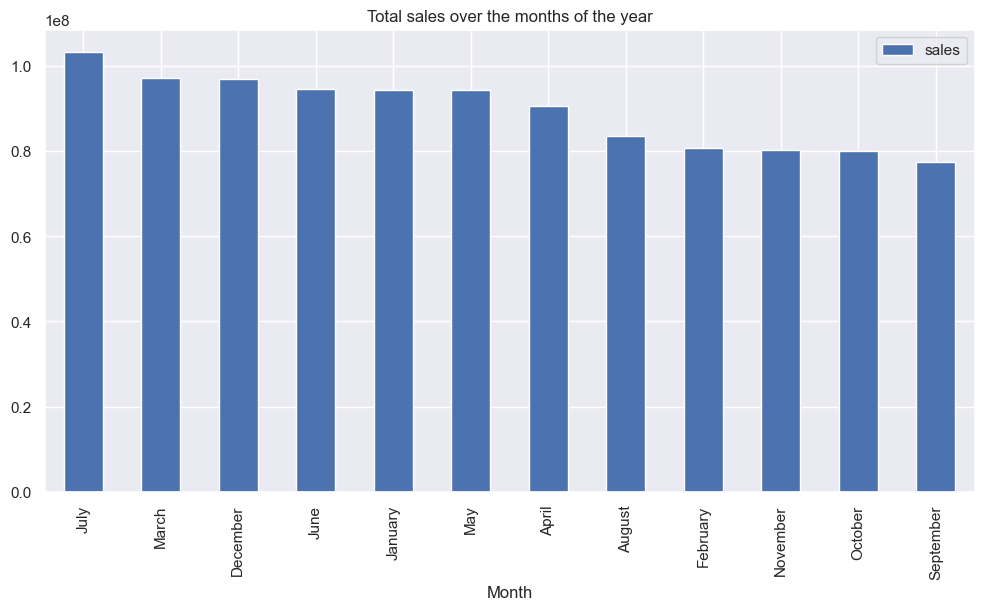

In [66]:
# plot the sum of sales by month of the year

ax = purchase_month.plot("Month", "sales", kind="bar", figsize=(12, 6),
                         title="Total sales over the months of the year")

- July(Summer) has the highest sales, followed by march (probaly easter), and december

##### Sales by Day of the week

In [67]:
# group the sum of sales by day of the week
# which day has the highest sales?

purchase_day = train_data.groupby("Day", as_index=False)["sales"].sum().sort_values(by="sales", ascending=False)
purchase_day = purchase_day.reset_index(drop=True)
purchase_day

Day          sales
0     Sunday 198,052,349.18
1   Saturday 186,101,548.14
2     Monday 148,827,793.85
3  Wednesday 142,378,692.83
4     Friday 139,097,846.66
5    Tuesday 137,922,113.28
6   Thursday 121,264,608.27

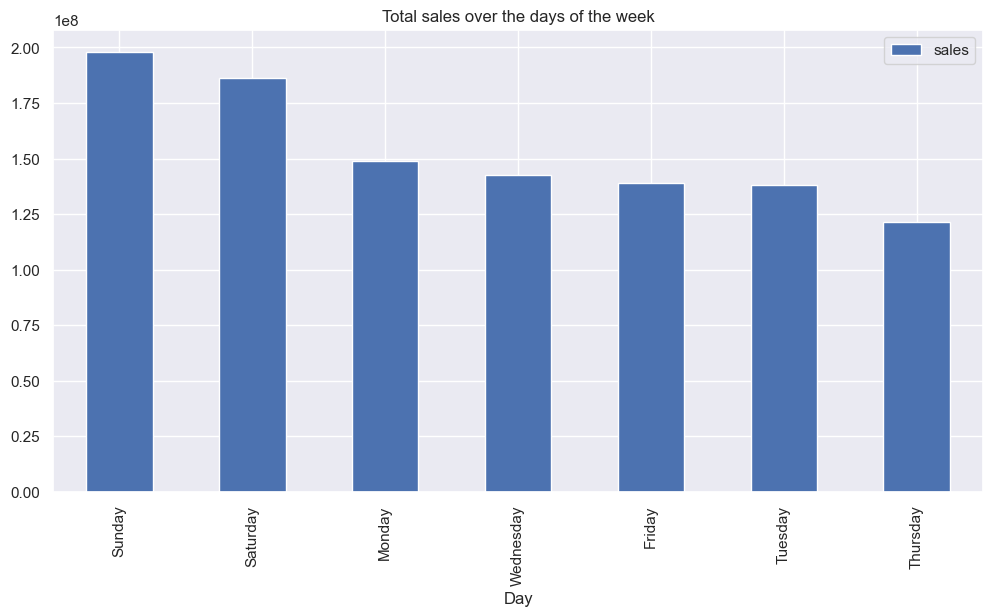

In [68]:
# plot the sum of sales by day of the week

ax = purchase_day.plot("Day", "sales", kind="bar", figsize=(12, 6),
                         title="Total sales over the days of the week")

- Sunday and saturday (weekends) have the highest sales

##### Sales by season

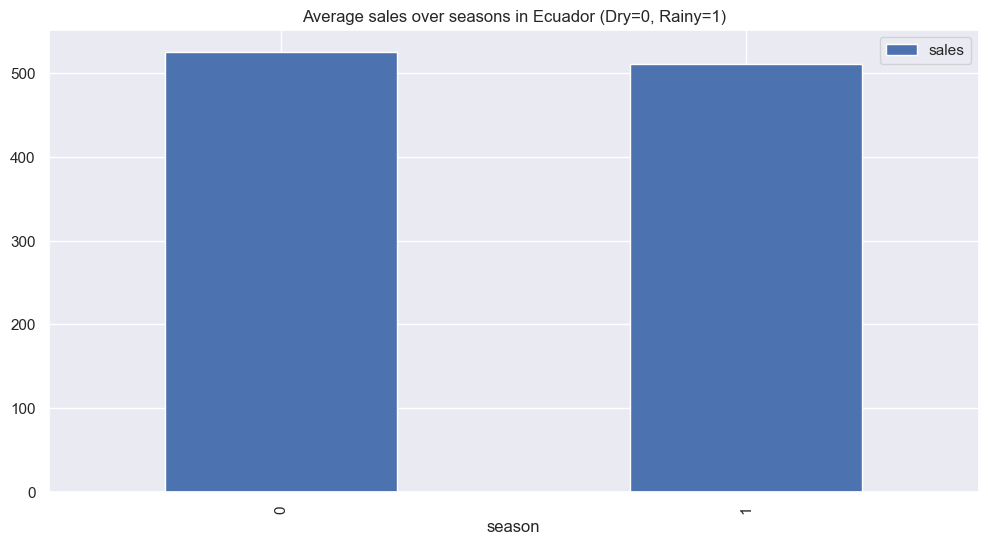

In [69]:
# create column for rainy and dry season

train_data["season"] = np.where(train_data["month"].isin([6,7,8,9]), 1, 0)

# plot sum of sales by season of the year (Dry or Rainy)
sales_by_season = train_data.groupby(["season"], as_index=False)['sales'].mean()

ax = sales_by_season.plot("season", "sales", kind="bar", figsize=(12, 6),
                          title="Average sales over seasons in Ecuador (Dry=0, Rainy=1)")


- Tropical countries like Ecuador have 2 seasons (Dry and rainy)
- Dry season has higher sales compared to rainy season

##### Sales by quarter

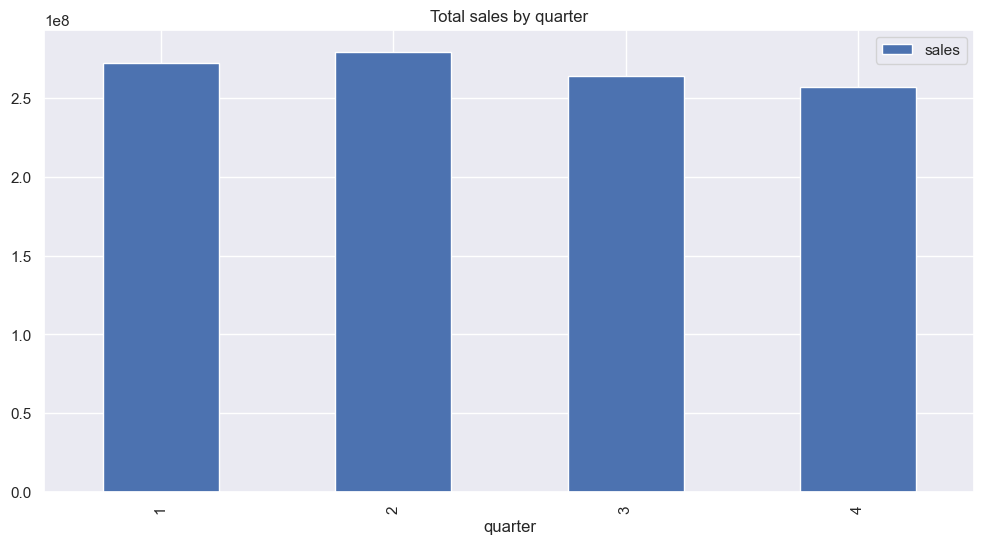

In [70]:
# plot the sum of sales by quarter of the year

sales_by_quarter = train_data.groupby(["quarter"], as_index=False)['sales'].sum()

ax = sales_by_quarter.plot("quarter", "sales", kind="bar", figsize=(12, 6),
                          title="Total sales by quarter")

##### 7. What is the difference between RMSLE, RMSE, MSE (or why is the MSE greater than all of them?)

- MSE( Mean Squared Error) is a widely used metric for regression problems.
It measures the average of the squared differences between predicted and actual values.
MSE is sensitive to outliers because it squares the differences.

- RMSE (Root Mean Squared Error) is the square root of the MSE.
It's often used because it has the same unit of measurement as the target variable, which makes it more interpretable.
RMSE treats all errors equally.

- RMSLE (Root Mean Squared Logarithmic Error) is commonly used when you want to penalize underpredictions more than overpredictions and when the target variable has a wide range.
It first takes the natural logarithm of the predicted and actual values and then computes the RMSE of those log values. RMSLE takes the logarithm of the values before computing the error, which can be useful when dealing with skewed data or when you want to give less weight to large errors for large values

-  MSE is greater because it is calculated as the average of the squared differences between predicted and actual values. When you square the differences between predicted and actual values, even small errors get larger because negative differences (i.e., underpredictions) become positive. It also magnifies larger errors, especially outliers.

## Hypothesis testing

**Null Hypothesis (H0)**:
"There is no significant relationship between store sales and promotions."

**Alternative Hypothesis (Ha)**:
"There is a significant relationship between store sales and promotions."

In [71]:
# encode categorical features

train_copy['onpromotion_encoded'] = np.where(train_copy['onpromotion'] >= 1, 1, 0)
train_copy['onpromotion_encoded'].value_counts()

onpromotion_encoded
0    1450446
1     611312
Name: count, dtype: int64

### T-test

The t-test is a statistical hypothesis test that assesses whether the means of two groups are significantly different from each other (an independent two-sample t-test)

In [72]:
# Extract the sales of products when they are on promotion and when they are not
sales_on_promotion = train_copy[train_copy['onpromotion_encoded'] == 1]['sales']
sales_not_on_promotion = train_copy[train_copy['onpromotion_encoded'] == 0]['sales']

# Calculate the sample sizes
n1 = len(sales_on_promotion)
n2 = len(sales_not_on_promotion)

# Calculate the degrees of freedom
degrees_of_freedom = n1 + n2 - 2  # Assuming equal variances, subtract 2 for two samples

# Set the significance level
alpha = 0.05

# Calculate the critical t-values for a two-tailed test
critical_t_value = t.ppf(1 - alpha / 2, degrees_of_freedom)

# Perform an independent two-sample t-test
t_stat, p_value = ttest_ind(sales_on_promotion, sales_not_on_promotion)

# Print the t-statistic, p-value, degrees of freedom, and critical t-values
print("t-statistic:", t_stat)
print("p-value:", p_value)
print("Degrees of Freedom:", degrees_of_freedom)
print(f"Critical t-value (α = {alpha/2}):", -critical_t_value)  # Left tail
print(f"Critical t-value (α = {alpha/2}):", critical_t_value)   # Right tail

# Check if the absolute t-statistic falls within the critical value range
if t_stat >= -critical_t_value and t_stat <= critical_t_value:
    print("\nThe absolute t-statistic falls within the critical value range.")
else:
    print("\nThe absolute t-statistic does not fall within the critical value range.")


t-statistic: 466.1532931598274
p-value: 0.0
Degrees of Freedom: 2061756
Critical t-value (α = 0.025): -1.9599651351478848
Critical t-value (α = 0.025): 1.9599651351478848

The absolute t-statistic does not fall within the critical value range.


- There is a statistically significant difference in sales between products when they are on promotion and when they are not on promotion (p-value < 0.05) and the t-statistic does not fall within the critical value range
- We have strong evidence to **reject the null hypothesis!!**

### Chi-Squared contingency test

- The chi-squared statistic measures the strength of the association or dependence between the two categorical variables

In [73]:
# Create contingency table
contingency_table = pd.crosstab(train_copy['onpromotion_encoded'], train_copy['sales'])

# Perform chi-squared test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Print results
print("Chi-squared statistic: ", chi2)
print("p-value: ", p)

Chi-squared statistic:  853431.6902295031
p-value:  0.0


- This indicates a strong association between the onpromotion and sales.

# 3. Data Preparation

- Deal with missing vales after merging, creating new features and adding missing dates
- Rename a few columns to be more readable
- Ensure dtypes are correct for each column

In [74]:
# shape overview to doubleckeck

train.shape, test.shape

((3000892, 6), (28512, 5))

In [75]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3000892 entries, 0 to 3
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           float64       
 1   date         datetime64[ns]
 2   store_nbr    float64       
 3   family       object        
 4   sales        float64       
 5   onpromotion  float64       
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 224.8+ MB


In [76]:
# check for duplicates

train.duplicated().any(), 
stores.duplicated().any(), 
oil.duplicated().any(),  
test.duplicated().any(),  
holidays.duplicated().any(),
transactions.duplicated().any()

False

In [77]:
# check for missing values in train data

train.isna().sum()

id             0
date           0
store_nbr      4
family         4
sales          0
onpromotion    0
dtype: int64

- we have some missing values, since we added missing dates

In [78]:
# Sort the merged DataFrame by date
train = train.sort_values('date')
# Resetting the index
train = train.reset_index(drop=True)
train.head()

id       date  store_nbr        family  sales  onpromotion
0     0.00 2013-01-01       1.00    AUTOMOTIVE   0.00         0.00
1 1,194.00 2013-01-01      42.00   CELEBRATION   0.00         0.00
2 1,193.00 2013-01-01      42.00  BREAD/BAKERY   0.00         0.00
3 1,192.00 2013-01-01      42.00         BOOKS   0.00         0.00
4 1,191.00 2013-01-01      42.00     BEVERAGES   0.00         0.00

In [79]:
train['store_nbr'].fillna(train['store_nbr'].mode()[0], inplace=True)

# Impute missing values in family column with mode
train['family'].fillna(train['family'].mode()[0], inplace=True)

In [80]:
train.isna().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

#### Oil Data

Text(0, 0.5, 'Price $')

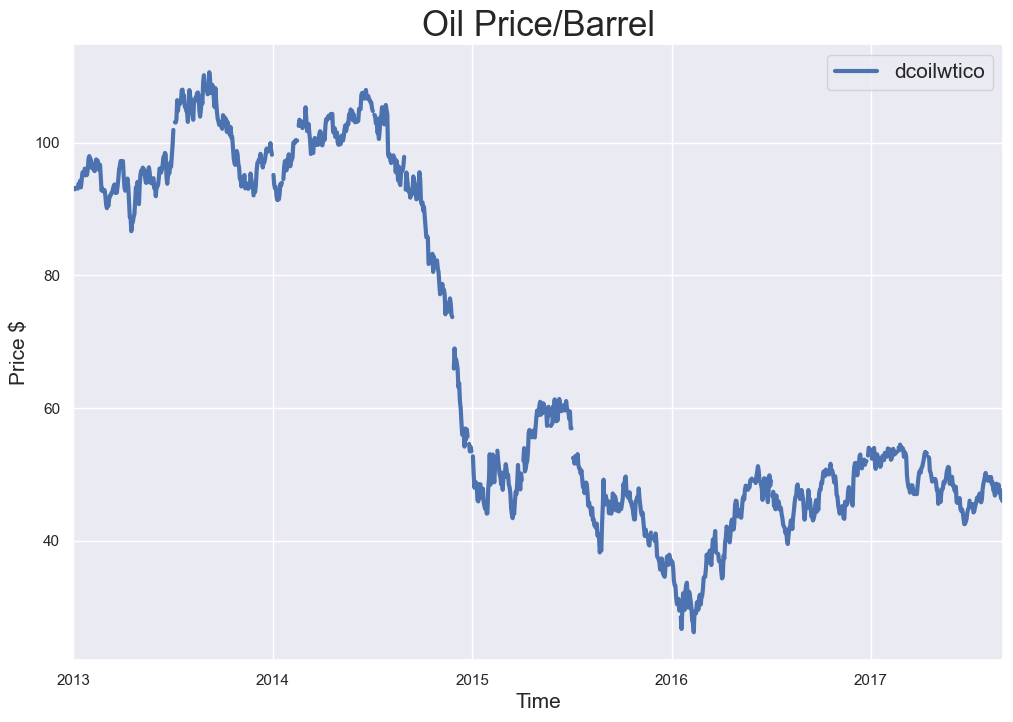

In [81]:
ax = oil.plot(x='date',y='dcoilwtico',title='Oil Price/Barrel',figsize=(12,8),linewidth=3)

ax.title.set_size(25)
plt.legend(fontsize=15)
plt.xlabel('Time',fontsize=15)
plt.ylabel('Price $',fontsize=15)

In [82]:
# we have some missing values in the oil dataset

oil['dcoilwtico'].isna().sum()

43

In [83]:
#percentage of the missing data
(oil.isna().sum()*100)/len(oil)

date         0.00
dcoilwtico   3.53
dtype: float64

In [84]:
oil_date_range = pd.date_range(start=oil['date'].min(),end=oil['date'].max())
missing_oil_dates = set(oil_date_range.date) - set(oil['date'].unique())

range_df =  pd.DataFrame(index=oil_date_range)
range_df.head()

Empty DataFrame
Columns: []
Index: [2013-01-01 00:00:00, 2013-01-02 00:00:00, 2013-01-03 00:00:00, 2013-01-04 00:00:00, 2013-01-05 00:00:00]

In [85]:
# Convert 'date' column in train DataFrame to datetime format
oil['date'] = pd.to_datetime(oil['date'])

In [86]:
#Merging with the rest of the columns
oil_merged = range_df.merge(oil, how='left', left_index=True, right_on='date')
oil_merged = oil_merged.sort_values('date')
oil_merged = oil_merged.reset_index(drop=True)
oil_merged.head()

date  dcoilwtico
0 2013-01-01         NaN
1 2013-01-02       93.14
2 2013-01-03       92.97
3 2013-01-04       93.12
4 2013-01-05         NaN

In [87]:
#Filling missing values in oil data

oil= oil_merged.interpolate(method="linear",limit_direction="both")
oil.head()

date  dcoilwtico
0 2013-01-01       93.14
1 2013-01-02       93.14
2 2013-01-03       92.97
3 2013-01-04       93.12
4 2013-01-05       93.15

In [88]:
# check again to confirm

oil['dcoilwtico'].isna().sum()

0

#### Holiday Data

In [89]:
holidays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         350 non-null    datetime64[ns]
 1   type         350 non-null    object        
 2   locale       350 non-null    object        
 3   locale_name  350 non-null    object        
 4   description  350 non-null    object        
 5   transferred  350 non-null    bool          
dtypes: bool(1), datetime64[ns](1), object(4)
memory usage: 14.1+ KB


In [90]:
holiday_date_range = pd.date_range(start=holidays['date'].min(),end=holidays['date'].max())
missing_holiday_dates = set(holiday_date_range.date) - set(holidays['date'].unique())

holiday_df = pd.DataFrame(index=holiday_date_range)
holiday_df.head()

Empty DataFrame
Columns: []
Index: [2012-03-02 00:00:00, 2012-03-03 00:00:00, 2012-03-04 00:00:00, 2012-03-05 00:00:00, 2012-03-06 00:00:00]

In [117]:
#merging
holidays = holiday_df.merge(holidays, how='left', left_index=True, right_on='date')
holidays = holidays.sort_values('date')
holidays = holidays.reset_index(drop=True)
holidays.head()

date     type locale locale_name         description transferred
0 2012-03-02  Holiday  Local       Manta  Fundacion de Manta       False
1 2012-03-03      NaN    NaN         NaN                 NaN         NaN
2 2012-03-04      NaN    NaN         NaN                 NaN         NaN
3 2012-03-05      NaN    NaN         NaN                 NaN         NaN
4 2012-03-06      NaN    NaN         NaN                 NaN         NaN

In [119]:
# Perform interpolation on the merged DataFrame using bfill
holidays= holidays.bfill()
holidays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2164 entries, 0 to 2163
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         2164 non-null   datetime64[ns]
 1   type         2164 non-null   object        
 2   locale       2164 non-null   object        
 3   locale_name  2164 non-null   object        
 4   description  2164 non-null   object        
 5   transferred  2164 non-null   bool          
dtypes: bool(1), datetime64[ns](1), object(4)
memory usage: 86.8+ KB


#### Preparing Train Data

In [103]:
train.head()

id       date  store_nbr        family  sales  onpromotion
0     0.00 2013-01-01       1.00    AUTOMOTIVE   0.00         0.00
1 1,194.00 2013-01-01      42.00   CELEBRATION   0.00         0.00
2 1,193.00 2013-01-01      42.00  BREAD/BAKERY   0.00         0.00
3 1,192.00 2013-01-01      42.00         BOOKS   0.00         0.00
4 1,191.00 2013-01-01      42.00     BEVERAGES   0.00         0.00

In [104]:
df_train1 = pd.merge(train, oil, on="date", how="inner")
df_train1.head()

id       date  store_nbr        family  sales  onpromotion  dcoilwtico
0     0.00 2013-01-01       1.00    AUTOMOTIVE   0.00         0.00       93.14
1 1,194.00 2013-01-01      42.00   CELEBRATION   0.00         0.00       93.14
2 1,193.00 2013-01-01      42.00  BREAD/BAKERY   0.00         0.00       93.14
3 1,192.00 2013-01-01      42.00         BOOKS   0.00         0.00       93.14
4 1,191.00 2013-01-01      42.00     BEVERAGES   0.00         0.00       93.14

In [105]:
# Merge train and stores datasets
df_train1 = pd.merge(df_train1, stores, on="store_nbr", how="left")
df_train1.head()

id       date  store_nbr        family  sales  onpromotion  \
0     0.00 2013-01-01       1.00    AUTOMOTIVE   0.00         0.00   
1 1,194.00 2013-01-01      42.00   CELEBRATION   0.00         0.00   
2 1,193.00 2013-01-01      42.00  BREAD/BAKERY   0.00         0.00   
3 1,192.00 2013-01-01      42.00         BOOKS   0.00         0.00   
4 1,191.00 2013-01-01      42.00     BEVERAGES   0.00         0.00   

   dcoilwtico    city      state type  cluster  
0       93.14   Quito  Pichincha    D       13  
1       93.14  Cuenca      Azuay    D        2  
2       93.14  Cuenca      Azuay    D        2  
3       93.14  Cuenca      Azuay    D        2  
4       93.14  Cuenca      Azuay    D        2

In [106]:
# Merge train and stores datasets
train = pd.merge(df_train1, holidays, on="date", how="left")
train.head()

id       date  store_nbr        family  sales  onpromotion  \
0     0.00 2013-01-01       1.00    AUTOMOTIVE   0.00         0.00   
1 1,194.00 2013-01-01      42.00   CELEBRATION   0.00         0.00   
2 1,193.00 2013-01-01      42.00  BREAD/BAKERY   0.00         0.00   
3 1,192.00 2013-01-01      42.00         BOOKS   0.00         0.00   
4 1,191.00 2013-01-01      42.00     BEVERAGES   0.00         0.00   

   dcoilwtico    city      state type_x  cluster   type_y    locale  \
0       93.14   Quito  Pichincha      D       13  Holiday  National   
1       93.14  Cuenca      Azuay      D        2  Holiday  National   
2       93.14  Cuenca      Azuay      D        2  Holiday  National   
3       93.14  Cuenca      Azuay      D        2  Holiday  National   
4       93.14  Cuenca      Azuay      D        2  Holiday  National   

  locale_name         description  transferred  
0     Ecuador  Primer dia del ano        False  
1     Ecuador  Primer dia del ano        False  
2     Ecuador  Primer dia del ano        False  
3     Ecuador  Primer dia del ano        False  
4     Ecuador  Primer dia del ano        False

In [107]:
#Checking for missing values for the merged dataset
train.isna().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dcoilwtico     0
city           0
state          0
type_x         0
cluster        0
type_y         0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64

In [108]:
train.set_index('date',inplace=True)

In [109]:
#Basic statistics of the merged dataset
train.describe().T

count         mean        std   min        25%  \
id          3,054,352.00 1,504,276.92 866,260.85  0.00 754,676.75   
store_nbr   3,054,352.00        27.50      15.59  1.00      14.00   
sales       3,054,352.00       359.02   1,107.29  0.00       0.00   
onpromotion 3,054,352.00         2.62      12.25  0.00       0.00   
dcoilwtico  3,054,352.00        67.79      25.70 26.19      46.28   
cluster     3,054,352.00         8.48       4.65  1.00       4.00   

                     50%          75%          max  
id          1,507,571.50 2,255,120.25 3,000,887.00  
store_nbr          27.00        41.00        54.00  
sales              11.00       196.01   124,717.00  
onpromotion         0.00         0.00       741.00  
dcoilwtico         53.19        95.80       110.62  
cluster             8.50        13.00        17.00

In [110]:
#drop categorical columns not relevant to analysis

train= train.drop(columns=["type_x", "locale", "locale_name", "description", "transferred"])
train.head()

id  store_nbr        family  sales  onpromotion  dcoilwtico  \
date                                                                           
2013-01-01     0.00       1.00    AUTOMOTIVE   0.00         0.00       93.14   
2013-01-01 1,194.00      42.00   CELEBRATION   0.00         0.00       93.14   
2013-01-01 1,193.00      42.00  BREAD/BAKERY   0.00         0.00       93.14   
2013-01-01 1,192.00      42.00         BOOKS   0.00         0.00       93.14   
2013-01-01 1,191.00      42.00     BEVERAGES   0.00         0.00       93.14   

              city      state  cluster   type_y  
date                                             
2013-01-01   Quito  Pichincha       13  Holiday  
2013-01-01  Cuenca      Azuay        2  Holiday  
2013-01-01  Cuenca      Azuay        2  Holiday  
2013-01-01  Cuenca      Azuay        2  Holiday  
2013-01-01  Cuenca      Azuay        2  Holiday

In [111]:
# remane columns with relevant names

train.rename(columns = {"cluster":"store_cluster", "dcoilwtico":"oil_price", "type_y":"events"}, inplace=True)


In [112]:
# check unique values in events column

train["events"].unique()

array(['Holiday', 'Work Day', 'Additional', 'Event', 'Transfer', 'Bridge'],
      dtype=object)

In [113]:
# Rename values in events column

train["events"].replace(to_replace={"Bridge", "Event", "Additional"}, value="Holiday", inplace=True) 
train["events"].replace(to_replace={"Work Day", "Transfer"}, value="No holiday", inplace=True)

In [114]:
train["events"].value_counts()

events
Holiday       2972380
No holiday      81972
Name: count, dtype: int64

In [115]:
# Replace 'holidays' with 1 and other events with 0

train['events'] = train['events'].replace('Holiday', 1).replace('No holiday', 0)

In [116]:
# check unique values

train["events"].unique()

array([1, 0], dtype=int64)

In [117]:
train["family"].unique()

array(['AUTOMOTIVE', 'CELEBRATION', 'BREAD/BAKERY', 'BOOKS', 'BEVERAGES',
       'BEAUTY', 'BABY CARE', 'SEAFOOD', 'SCHOOL AND OFFICE SUPPLIES',
       'PRODUCE', 'PREPARED FOODS', 'POULTRY', 'PLAYERS AND ELECTRONICS',
       'PET SUPPLIES', 'PERSONAL CARE', 'MEATS', 'MAGAZINES',
       'LIQUOR,WINE,BEER', 'LINGERIE', 'LAWN AND GARDEN', 'LADIESWEAR',
       'HOME CARE', 'HOME APPLIANCES', 'CLEANING', 'DAIRY', 'DELI',
       'EGGS', 'HOME AND KITCHEN II', 'HOME AND KITCHEN I', 'HARDWARE',
       'GROCERY II', 'GROCERY I', 'FROZEN FOODS'], dtype=object)

In [118]:
# reclassification of product family to reduce number of categorical variables to encode

def reclassify_family(train):
    train["family"].replace(to_replace={"GROCERY I", "GROCERY II", "EGGS", "PRODUCE", "DAIRY", "BREAD/BAKERY", "DELI", "PREPARED FOODS"}, value="GROCERY", inplace=True)
    train["family"].replace(to_replace={"HOME AND KITCHEN I", "HOME AND KITCHEN II", "HOME APPLIANCES", "PLAYERS AND ELECTRONICS"}, value="HOME AND KITCHEN", inplace=True)
    train["family"].replace(to_replace={"MEATS", "POULTRY", "SEAFOOD", "FROZEN FOODS"}, value="MEATS & FROZEN FOODS", inplace=True)
    train["family"].replace(to_replace={"HOME CARE", "LAWN AND GARDEN", "CLEANING", "PET SUPPLIES"}, value="HOME CARE AND GARDEN", inplace=True)
    train["family"].replace(to_replace={"BEAUTY", "BABY CARE", "LADIESWEAR", "LINGERIE", "PERSONAL CARE"}, value="BEAUTY AND FASHION", inplace=True)
    train["family"].replace(to_replace={"LIQUOR,WINE,BEER", "BEVERAGES"}, value="BEVERAGES AND LIQUOR", inplace=True)
    train["family"].replace(to_replace={"MAGAZINES", "BOOKS", "CELEBRATION", "SCHOOL AND OFFICE SUPPLIES"}, value="STATIONERY & OFFICE SUPPLIES", inplace=True)
    train["family"].replace(to_replace={"AUTOMOTIVE", "HARDWARE"}, value="AUTOMOTIVE & HARDWARE", inplace=True)


reclassify_family(train)

In [119]:
# check unique

train["family"].unique()

array(['AUTOMOTIVE & HARDWARE', 'STATIONERY & OFFICE SUPPLIES', 'GROCERY',
       'BEVERAGES AND LIQUOR', 'BEAUTY AND FASHION',
       'MEATS & FROZEN FOODS', 'HOME AND KITCHEN', 'HOME CARE AND GARDEN'],
      dtype=object)

In [120]:
# Check for missing values

train.isna().sum()

id               0
store_nbr        0
family           0
sales            0
onpromotion      0
oil_price        0
city             0
state            0
store_cluster    0
events           0
dtype: int64

In [121]:
train.head()

id  store_nbr                        family  sales  \
date                                                                  
2013-01-01     0.00       1.00         AUTOMOTIVE & HARDWARE   0.00   
2013-01-01 1,194.00      42.00  STATIONERY & OFFICE SUPPLIES   0.00   
2013-01-01 1,193.00      42.00                       GROCERY   0.00   
2013-01-01 1,192.00      42.00  STATIONERY & OFFICE SUPPLIES   0.00   
2013-01-01 1,191.00      42.00          BEVERAGES AND LIQUOR   0.00   

            onpromotion  oil_price    city      state  store_cluster  events  
date                                                                          
2013-01-01         0.00      93.14   Quito  Pichincha             13       1  
2013-01-01         0.00      93.14  Cuenca      Azuay              2       1  
2013-01-01         0.00      93.14  Cuenca      Azuay              2       1  
2013-01-01         0.00      93.14  Cuenca      Azuay              2       1  
2013-01-01         0.00      93.14  Cuenca      Azuay              2       1

In [122]:
train.drop(columns=['id', 'city', 'state'], inplace=True)

In [123]:
train.head()

store_nbr                        family  sales  onpromotion  \
date                                                                      
2013-01-01       1.00         AUTOMOTIVE & HARDWARE   0.00         0.00   
2013-01-01      42.00  STATIONERY & OFFICE SUPPLIES   0.00         0.00   
2013-01-01      42.00                       GROCERY   0.00         0.00   
2013-01-01      42.00  STATIONERY & OFFICE SUPPLIES   0.00         0.00   
2013-01-01      42.00          BEVERAGES AND LIQUOR   0.00         0.00   

            oil_price  store_cluster  events  
date                                          
2013-01-01      93.14             13       1  
2013-01-01      93.14              2       1  
2013-01-01      93.14              2       1  
2013-01-01      93.14              2       1  
2013-01-01      93.14              2       1

### Resampling

In [124]:
train = train.groupby(['family', pd.Grouper(freq='D')]).agg({
    'store_nbr': 'first',
    'sales': 'sum',
    'onpromotion': 'sum',
    'oil_price': 'first',
    'store_cluster': 'first',
    'events': 'first',
}).reset_index()

In [125]:
train.tail()

family       date  store_nbr    sales  \
13471  STATIONERY & OFFICE SUPPLIES 2017-08-11      42.00 4,893.00   
13472  STATIONERY & OFFICE SUPPLIES 2017-08-12      42.00 4,976.00   
13473  STATIONERY & OFFICE SUPPLIES 2017-08-13      42.00 4,732.00   
13474  STATIONERY & OFFICE SUPPLIES 2017-08-14      42.00 3,877.00   
13475  STATIONERY & OFFICE SUPPLIES 2017-08-15      42.00 3,588.00   

       onpromotion  oil_price  store_cluster  events  
13471       144.00      48.81              2       0  
13472       150.00      47.59              2       1  
13473       150.00      47.59              2       1  
13474       154.00      47.59              2       1  
13475       148.00      47.57              2       1

### Feature Engineering

In [126]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13476 entries, 0 to 13475
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   family         13476 non-null  object        
 1   date           13476 non-null  datetime64[ns]
 2   store_nbr      13476 non-null  float64       
 3   sales          13476 non-null  float64       
 4   onpromotion    13476 non-null  float64       
 5   oil_price      13476 non-null  float64       
 6   store_cluster  13476 non-null  int64         
 7   events         13476 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(2), object(1)
memory usage: 842.4+ KB


In [127]:
train = train.set_index('date')

In [128]:
# Create new features

def create_date_features(train):
    train["Year"] = train.index.year
    train["Month"] = train.index.month
    train['Day'] = train.index.day
    train['Quarter'] = train.index.quarter 
    train['Week'] = train.index.isocalendar().week
    train['day_of_week'] = train.index.dayofweek
    train["is_weekend"] = np.where(train['day_of_week'] > 4, 1, 0)


create_date_features(train)

### Lag Features

In [129]:
# def create_lagged_features(train):
#     """

#     Parameters:
#     train (DataFrame): The DataFrame containing the data.

#     Returns:
#     DataFrame: The DataFrame with lagged features added.
#     """
#     train['sales_lag_1'] = train['sales'].shift(1)
#     train['sales_lag_7'] = train['sales'].shift(7)
#     train['week_lag_1'] = train['Week'].shift(1)
#     return train

# train = create_lagged_features(train)

In [130]:
# # Calculate rolling averages for 'sales'
# window = 7  # With a window size of 7
# train['sales_rolling_avg'] = train['sales'].rolling(window=window).mean()

In [131]:
train.reset_index(inplace=True)

In [132]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13476 entries, 0 to 13475
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           13476 non-null  datetime64[ns]
 1   family         13476 non-null  object        
 2   store_nbr      13476 non-null  float64       
 3   sales          13476 non-null  float64       
 4   onpromotion    13476 non-null  float64       
 5   oil_price      13476 non-null  float64       
 6   store_cluster  13476 non-null  int64         
 7   events         13476 non-null  int64         
 8   Year           13476 non-null  int32         
 9   Month          13476 non-null  int32         
 10  Day            13476 non-null  int32         
 11  Quarter        13476 non-null  int32         
 12  Week           13476 non-null  UInt32        
 13  day_of_week    13476 non-null  int32         
 14  is_weekend     13476 non-null  int32         
dtypes: UInt32(1), datet

In [133]:
train.isna().sum()

date             0
family           0
store_nbr        0
sales            0
onpromotion      0
oil_price        0
store_cluster    0
events           0
Year             0
Month            0
Day              0
Quarter          0
Week             0
day_of_week      0
is_weekend       0
dtype: int64

In [134]:
# def replace_missing_with_mode(train, columns):
#     """
#     Replace missing values in specified columns with the mode.
#     """
#     for col in columns:
#         mode_value = train[col].mode()[0]
#         train[col] = train[col].fillna(mode_value)
#     return train


# columns_to_replace = ['week_lag_1']
# train = replace_missing_with_mode(train, columns_to_replace)


In [135]:
train = train.set_index('date')
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13476 entries, 2013-01-01 to 2017-08-15
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   family         13476 non-null  object 
 1   store_nbr      13476 non-null  float64
 2   sales          13476 non-null  float64
 3   onpromotion    13476 non-null  float64
 4   oil_price      13476 non-null  float64
 5   store_cluster  13476 non-null  int64  
 6   events         13476 non-null  int64  
 7   Year           13476 non-null  int32  
 8   Month          13476 non-null  int32  
 9   Day            13476 non-null  int32  
 10  Quarter        13476 non-null  int32  
 11  Week           13476 non-null  UInt32 
 12  day_of_week    13476 non-null  int32  
 13  is_weekend     13476 non-null  int32  
dtypes: UInt32(1), float64(4), int32(6), int64(2), object(1)
memory usage: 1.2+ MB


In [136]:
train.isna().sum()

family           0
store_nbr        0
sales            0
onpromotion      0
oil_price        0
store_cluster    0
events           0
Year             0
Month            0
Day              0
Quarter          0
Week             0
day_of_week      0
is_weekend       0
dtype: int64

In [137]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13476 entries, 2013-01-01 to 2017-08-15
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   family         13476 non-null  object 
 1   store_nbr      13476 non-null  float64
 2   sales          13476 non-null  float64
 3   onpromotion    13476 non-null  float64
 4   oil_price      13476 non-null  float64
 5   store_cluster  13476 non-null  int64  
 6   events         13476 non-null  int64  
 7   Year           13476 non-null  int32  
 8   Month          13476 non-null  int32  
 9   Day            13476 non-null  int32  
 10  Quarter        13476 non-null  int32  
 11  Week           13476 non-null  UInt32 
 12  day_of_week    13476 non-null  int32  
 13  is_weekend     13476 non-null  int32  
dtypes: UInt32(1), float64(4), int32(6), int64(2), object(1)
memory usage: 1.2+ MB


In [138]:
# save to csv

# train.to_csv('Dataset/regression_train_data.csv', index=True)

### Data Splitting

In [ ]:
split_date = '2016-08-15'

# Create train and test splits based on the index order
training_set = train.loc[train.index <= split_date]
eval_set = train.loc[train.index > split_date]

training_set.shape, eval_set.shape

((10563, 14), (2913, 14))

In [ ]:
# Training data
X_train = training_set.drop(columns = ["sales"])
y_train = training_set["sales"]

#Evaluation  set
X_eval = eval_set.drop(columns = ["sales"])
y_eval = eval_set["sales"]

X_train.shape, y_train.shape, X_eval.shape, y_eval.shape

((10563, 13), (10563,), (2913, 13), (2913,))

### Encoding & Scaling

In [ ]:
# Identify numeric and non-numeric columns
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_train.select_dtypes(exclude=[np.number]).columns.tolist()

In [ ]:
# Define transformers for numerical and categorical columns
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ])

# Create the pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])


In [ ]:
# Fit and transform the data
X_processed = pipeline.fit_transform(X_train)

# Extracting feature names for numerical columns
num_feature_names = num_cols

# Extracting feature names for categorical columns after one-hot encoding
cat_encoder = pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
cat_feature_names = cat_encoder.get_feature_names_out(cat_cols)

# Concatenating numerical and categorical feature names
feature_names = num_feature_names + list(cat_feature_names)

# Convert X_processed to DataFrame
X_processed_df = pd.DataFrame(X_processed, columns=feature_names)
X_processed_df.head()

store_nbr  onpromotion  oil_price  store_cluster  events  Year  Month  \
0     -43.69        -0.29       0.75          10.36    0.17 -1.27  -1.52   
1       0.44        -0.29       0.75          -0.80   -5.73 -1.27  -1.52   
2       0.44        -0.29       0.74          -0.80   -5.73 -1.27  -1.52   
3       0.44        -0.29       0.75          -0.80   -5.73 -1.27  -1.52   
4       0.44        -0.29       0.75          -0.80   -5.73 -1.27  -1.52   

    Day  Quarter  Week  day_of_week  is_weekend  family_AUTOMOTIVE & HARDWARE  \
0 -1.66    -1.27 -1.62        -1.00       -0.63                          1.00   
1 -1.55    -1.27 -1.62        -0.50       -0.63                          1.00   
2 -1.43    -1.27 -1.62         0.00       -0.63                          1.00   
3 -1.32    -1.27 -1.62         0.50       -0.63                          1.00   
4 -1.21    -1.27 -1.62         1.00        1.58                          1.00   

   family_BEAUTY AND FASHION  family_BEVERAGES AND LIQUOR  family_GROCERY  \
0                       0.00                         0.00            0.00   
1                       0.00                         0.00            0.00   
2                       0.00                         0.00            0.00   
3                       0.00                         0.00            0.00   
4                       0.00                         0.00            0.00   

   family_HOME AND KITCHEN  family_HOME CARE AND GARDEN  \
0                     0.00                         0.00   
1                     0.00                         0.00   
2                     0.00                         0.00   
3                     0.00                         0.00   
4                     0.00                         0.00   

   family_MEATS & FROZEN FOODS  family_STATIONERY & OFFICE SUPPLIES  
0                         0.00                                 0.00  
1                         0.00                                 0.00  
2                         0.00                                 0.00  
3                         0.00                                 0.00  
4                         0.00                                 0.00

In [ ]:
y_train.reset_index(drop=True,inplace=True)

In [ ]:
X_eval.tail()

family  store_nbr  onpromotion  oil_price  \
date                                                                          
2017-08-11  STATIONERY & OFFICE SUPPLIES      42.00       144.00      48.81   
2017-08-12  STATIONERY & OFFICE SUPPLIES      42.00       150.00      47.59   
2017-08-13  STATIONERY & OFFICE SUPPLIES      42.00       150.00      47.59   
2017-08-14  STATIONERY & OFFICE SUPPLIES      42.00       154.00      47.59   
2017-08-15  STATIONERY & OFFICE SUPPLIES      42.00       148.00      47.57   

            store_cluster  events  Year  Month  Day  Quarter  Week  \
date                                                                 
2017-08-11              2       0  2017      8   11        3    32   
2017-08-12              2       1  2017      8   12        3    32   
2017-08-13              2       1  2017      8   13        3    32   
2017-08-14              2       1  2017      8   14        3    33   
2017-08-15              2       1  2017      8   15        3    33   

            day_of_week  is_weekend  
date                                 
2017-08-11            4           0  
2017-08-12            5           1  
2017-08-13            6           1  
2017-08-14            0           0  
2017-08-15            1           0

In [ ]:
X_processed = pipeline.fit_transform(X_eval)

# Extracting feature names for numerical columns
num_feature_names = num_cols

# Extracting feature names for categorical columns after one-hot encoding
cat_encoder = pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
cat_feature_names = cat_encoder.get_feature_names_out(cat_cols)

# Concatenating numerical and categorical feature names
feature_names = num_feature_names + list(cat_feature_names)

# Convert X_processed to DataFrame
X_processed_df_eval = pd.DataFrame(X_processed, columns=feature_names)
X_processed_df_eval.head()

store_nbr  onpromotion  oil_price  store_cluster  events  Year  Month  Day  \
0       0.26        -0.59      -0.73          -0.59    0.12 -1.29   0.43 0.03   
1       0.26        -0.59      -0.66          -0.59    0.12 -1.29   0.43 0.15   
2       0.26        -0.59      -0.21          -0.59    0.12 -1.29   0.43 0.26   
3       0.26        -0.59      -0.12          -0.59    0.12 -1.29   0.43 0.38   
4       0.26        -0.59      -0.66          -0.59    0.12 -1.29   0.43 0.49   

   Quarter  Week  day_of_week  is_weekend  family_AUTOMOTIVE & HARDWARE  \
0     0.44  0.44        -1.00       -0.63                          1.00   
1     0.44  0.44        -0.49       -0.63                          1.00   
2     0.44  0.44         0.01       -0.63                          1.00   
3     0.44  0.44         0.51       -0.63                          1.00   
4     0.44  0.44         1.01        1.59                          1.00   

   family_BEAUTY AND FASHION  family_BEVERAGES AND LIQUOR  family_GROCERY  \
0                       0.00                         0.00            0.00   
1                       0.00                         0.00            0.00   
2                       0.00                         0.00            0.00   
3                       0.00                         0.00            0.00   
4                       0.00                         0.00            0.00   

   family_HOME AND KITCHEN  family_HOME CARE AND GARDEN  \
0                     0.00                         0.00   
1                     0.00                         0.00   
2                     0.00                         0.00   
3                     0.00                         0.00   
4                     0.00                         0.00   

   family_MEATS & FROZEN FOODS  family_STATIONERY & OFFICE SUPPLIES  
0                         0.00                                 0.00  
1                         0.00                                 0.00  
2                         0.00                                 0.00  
3                         0.00                                 0.00  
4                         0.00                                 0.00

In [ ]:
y_eval.reset_index(drop=True,inplace=True)

## 4. Modelling

In [ ]:
mean_baseline = y_train.mean()
median_baseline = y_train.median()

# Calculate RMSE for the baseline models
rmse_mean_baseline = np.sqrt(mean_squared_error(y_train, [mean_baseline] * len(y_train)))
rmse_median_baseline = np.sqrt(mean_squared_error(y_train, [median_baseline] * len(y_train)))

print(f'RMSE for Mean Baseline: {rmse_mean_baseline}')
print(f'RMSE for Median Baseline: {rmse_median_baseline}')

RMSE for Mean Baseline: 123780.63776431134
RMSE for Median Baseline: 132447.64605557334


### Linear Regression

In [ ]:
LR = LinearRegression()
LR.fit(X_processed_df, y_train)

LinearRegression()

In [ ]:
# Make prediction on test
LR_pred = LR.predict(X_processed_df_eval)

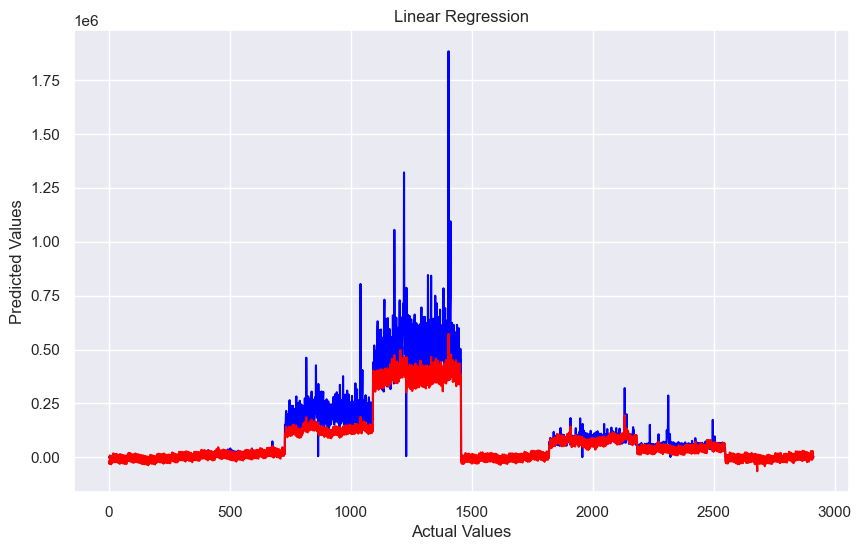

In [ ]:
# plot the actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_eval, color='blue')
plt.plot(LR_pred,color='red')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Linear Regression")
plt.show()

In [ ]:
#Model Evalution
mse = mean_squared_error(y_eval, LR_pred)
rmse = np.sqrt(mse)

# Combining the evaluation metrics
results = pd.DataFrame([['Linear Regression', mse, rmse]], columns = ['Model', 'MSE', 'RMSE'])
results

Model              MSE      RMSE
0  Linear Regression 5,106,210,243.48 71,457.75

### Decision tree

In [ ]:
DT = DecisionTreeRegressor(random_state=42)
DT.fit(X_processed_df, y_train)

DecisionTreeRegressor(random_state=42)

In [ ]:
# Make prediction on test
DT_pred = DT.predict(X_processed_df_eval)

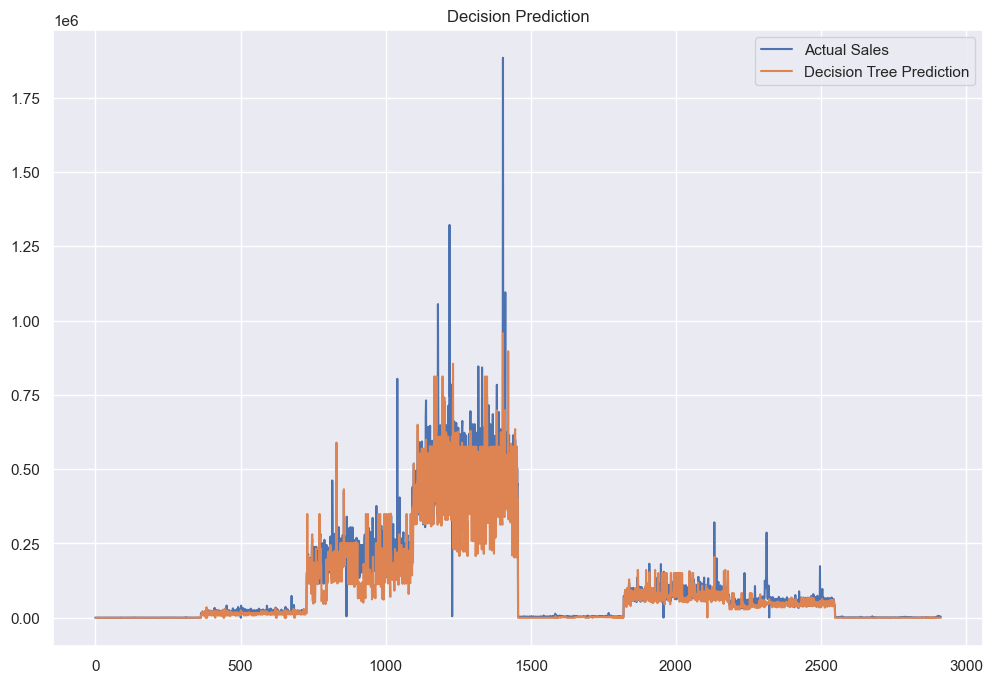

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(y_eval, label ='Actual Sales')
plt.plot(DT_pred, label='Decision Tree Prediction')
plt.legend(loc='best')
plt.title('Decision Prediction')
plt.show()

In [ ]:
# Evaluation metrics

mse = mean_squared_error(y_eval, DT_pred)
msle = mean_squared_log_error(y_eval, DT_pred)
rmse = np.sqrt(mean_squared_error(y_eval, DT_pred)).round(2)
rmsle = np.sqrt(mean_squared_log_error(y_eval, DT_pred)).round(2)

results2 = pd.DataFrame([['Decision Tree', mse,msle, rmse, rmsle]], columns = ['Model', 'MSE', 'MSLE', 'RMSE', 'RMSLE'])
results_ = pd.concat([results, results2], ignore_index=True)
results_

Model              MSE      RMSE  MSLE  RMSLE
0  Linear Regression 5,106,210,243.48 71,457.75   NaN    NaN
1      Decision Tree 3,943,703,579.57 62,798.91  5.90   2.43

### Random Forest

In [ ]:
RF = RandomForestRegressor(random_state=42)
RF.fit(X_processed_df, y_train)

RandomForestRegressor(random_state=42)

In [ ]:
# Make prediction on test
RF_pred = RF.predict(X_processed_df_eval)

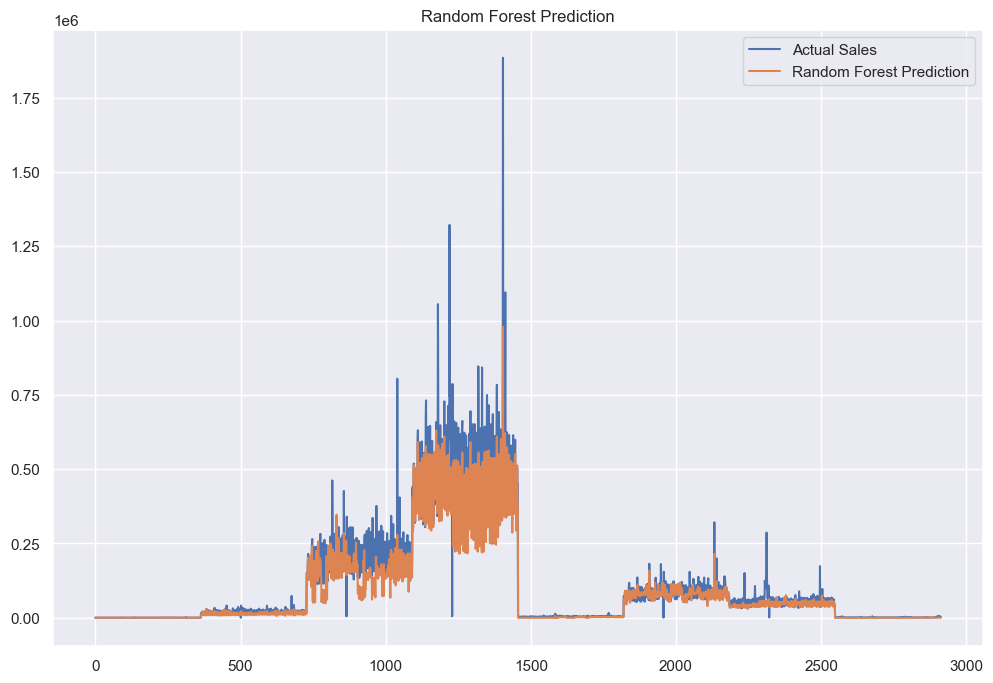

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(y_eval, label ='Actual Sales')
plt.plot(RF_pred, label='Random Forest Prediction')
plt.legend(loc='best')
plt.title('Random Forest Prediction')
plt.show()

In [ ]:
# Evaluation metrics

mse = mean_squared_error(y_eval, RF_pred)
msle = mean_squared_log_error(y_eval, RF_pred)
rmse = np.sqrt(mean_squared_error(y_eval, RF_pred)).round(2)
rmsle = np.sqrt(mean_squared_log_error(y_eval, RF_pred)).round(2)

results3 = pd.DataFrame([['Random Forest', mse,msle, rmse, rmsle]], columns = ['Model', 'MSE', 'MSLE', 'RMSE', 'RMSLE'])
results_3 = pd.concat([results_, results3], ignore_index=True)
results_3

Model              MSE      RMSE  MSLE  RMSLE
0  Linear Regression 5,106,210,243.48 71,457.75   NaN    NaN
1      Decision Tree 3,943,703,579.57 62,798.91  5.90   2.43
2      Random Forest 2,956,725,621.73 54,375.78  2.75   1.66

### K-Nearest Neighbours Regression Model(KNN)

In [ ]:
knn = KNeighborsRegressor(n_neighbors=10)  # Set the number of neighbors (you can adjust this value)
knn.fit(X_processed_df, y_train)

KNeighborsRegressor(n_neighbors=10)

In [ ]:
# Make prediction on test
knn_y_pred = knn.predict(X_processed_df_eval)

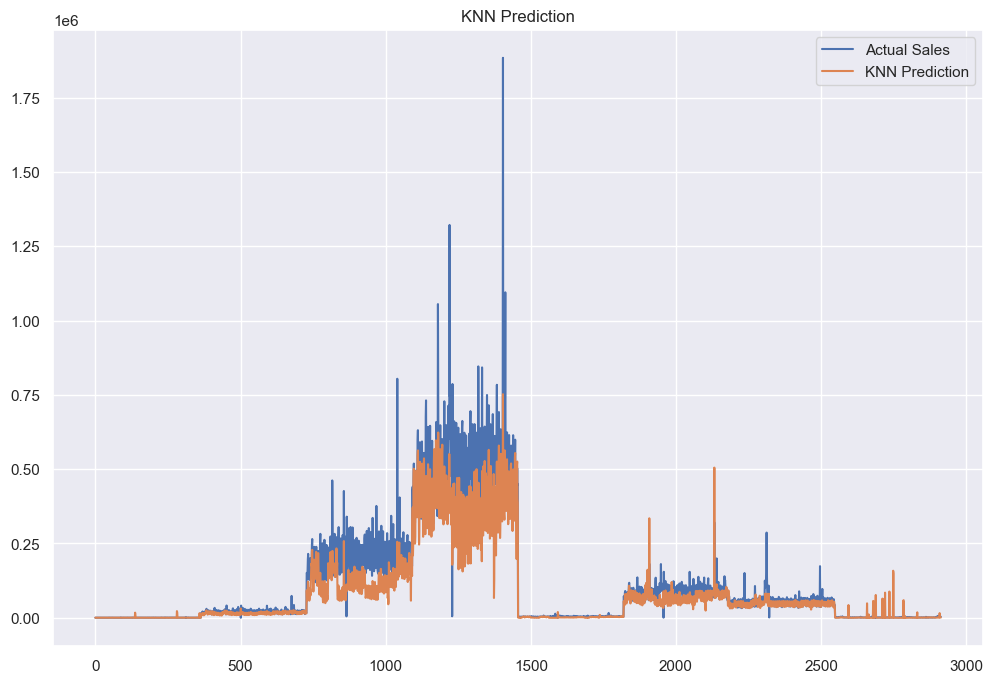

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(y_eval, label ='Actual Sales')
plt.plot(knn_y_pred, label='KNN Prediction')
plt.legend(loc='best')
plt.title('KNN Prediction')
plt.show()

In [ ]:
mse = mean_squared_error(y_eval, knn_y_pred)
msle = mean_squared_log_error(y_eval, knn_y_pred)
rmse = np.sqrt(mean_squared_error(y_eval, knn_y_pred)).round(2)
rmsle = np.sqrt(mean_squared_log_error(y_eval, knn_y_pred)).round(2)

results4 = pd.DataFrame([['KNN', mse,msle, rmse, rmsle]], columns = ['Model', 'MSE', 'MSLE', 'RMSE', 'RMSLE'])
results_4 = pd.concat([results_3, results4], ignore_index=True)
results_4

Model              MSE      RMSE  MSLE  RMSLE
0  Linear Regression 5,106,210,243.48 71,457.75   NaN    NaN
1      Decision Tree 3,943,703,579.57 62,798.91  5.90   2.43
2      Random Forest 2,956,725,621.73 54,375.78  2.75   1.66
3                KNN 5,046,377,685.20 71,037.86  1.58   1.26

### Xg Boost

In [ ]:
xgb = xgb.XGBRegressor(random_state=42, n_estimators=1000)
xgb.fit(X_processed_df, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [ ]:
# Make prediction on test
xgb_y_pred = xgb.predict(X_processed_df_eval)

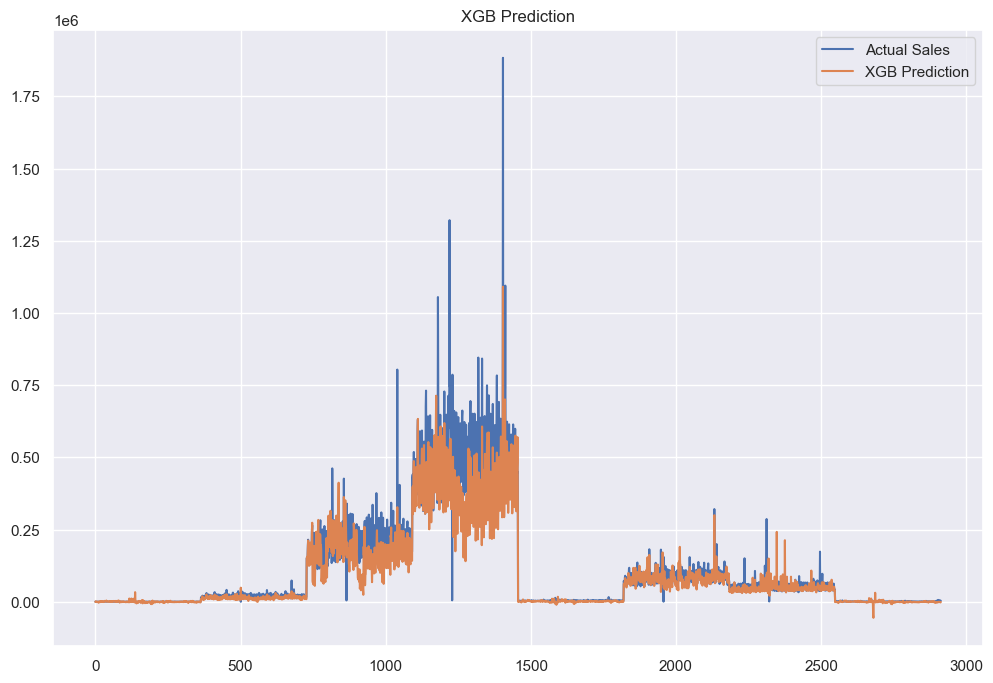

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(y_eval, label ='Actual Sales')
plt.plot(xgb_y_pred, label='XGB Prediction')
plt.legend(loc='best')
plt.title('XGB Prediction')
plt.show()

In [ ]:
mse = mean_squared_error(y_eval, xgb_y_pred)
rmse = np.sqrt(mean_squared_error(y_eval, xgb_y_pred)).round(2)

results5 = pd.DataFrame([['XGB', mse, rmse]], columns = ['Model', 'MSE', 'RMSE'])
results_5 = pd.concat([results_4, results5], ignore_index=True)
results_5

Model              MSE      RMSE  MSLE  RMSLE
0  Linear Regression 5,106,210,243.48 71,457.75   NaN    NaN
1      Decision Tree 3,943,703,579.57 62,798.91  5.90   2.43
2      Random Forest 2,956,725,621.73 54,375.78  2.75   1.66
3                KNN 5,046,377,685.20 71,037.86  1.58   1.26
4                XGB 3,489,141,273.43 59,068.95   NaN    NaN

In [ ]:
# Calculate feature importances using permutation importance
result = permutation_importance(knn, X_processed_df, y_train, n_repeats=10, random_state=42)

# Get feature importances from the result
importance_df = pd.DataFrame({'Feature': X_processed_df.columns, 'Importance': result.importances_mean})

# Sort the features by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df)


                                Feature  Importance
1                           onpromotion        0.47
15                       family_GROCERY        0.23
11                           is_weekend        0.11
3                         store_cluster        0.09
14          family_BEVERAGES AND LIQUOR        0.04
2                             oil_price        0.03
10                          day_of_week        0.03
16              family_HOME AND KITCHEN        0.03
12         family_AUTOMOTIVE & HARDWARE        0.03
19  family_STATIONERY & OFFICE SUPPLIES        0.03
5                                  Year        0.03
13            family_BEAUTY AND FASHION        0.02
17          family_HOME CARE AND GARDEN        0.02
18          family_MEATS & FROZEN FOODS        0.02
9                                  Week        0.01
8                               Quarter        0.01
7                                   Day        0.01
4                                events        0.00
6           

In [ ]:
predictions_knn = knn.predict(X_processed_df_eval)
data = {'Actual': y_eval, 'Predicted': predictions_knn}
df_predictions = pd.DataFrame(data)
df_predictions.head(10)

Actual  Predicted
0  390.00     303.70
1  386.00     286.50
2  321.00     281.10
3  374.00     286.10
4  481.00     444.00
5  554.00     466.30
6  394.00     343.90
7  336.00     331.90
8  364.00     373.00
9  313.00     273.00

### Save Model

In [ ]:
destination = "./toolkit"

#create a directory if it doesn't exist
if not os.path.exists(destination):
    os.makedirs(destination)

#Create a dictionary  to store the object and their filename
models ={
    "pipeline":pipeline,
    "model":knn
}

#Loop through the model and save them using joblib.dump()
for name,model in models.items():
    file_path =os.path.join(destination,f"{name}.joblib")
    joblib.dump(model,file_path)